In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [34]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [35]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [36]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# sum of cases each year
cases_sum = df.groupby(['year'])['cases'].sum().reset_index()

print(cases_sum)

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    year   cases
0   2012  254010
1   2013  256911
2   2014   15150
3   2015   94824
4   2016  112646
5   2017   17257
6   2018   25184
7   2019   50378
8   2020    8021
9   2021    5445
10  2022   23100


In [37]:
selected_columns = ['week', 'city', 'cases', 'cases_per_100k', 'temp_avg', 'humidity_avg',
                    'precipitation_avg_ordinary_kriging', 'vim',
                'month_sin', 'month_cos', 'week_sin', 'week_cos']

df = df[selected_columns]

In [38]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0, 1])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['precipitation_avg_ordinary_kriging']
data = create_lags(data, group_col='city', target_col=weather_columns, lags=[3, 4])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
data = create_lags(data, group_col='city', target_col='cases', lags=[0], inplace = True)

data = data.dropna().reset_index(drop=True)

In [39]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min', 'cases_per_100k', 'vim',
                   'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging',
                   'nearby_cases_weighted']
lagged_vars = [col for col in data.columns if '_lag' in col]

# Filter scaler_vars to only include variables that are in data.columns
scaler_vars = [col for col in continuous_vars + lagged_vars if col in data.columns]

In [40]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 202053)]
test_data = data[(data['week'] > 202053)]

# Create a copy of test_data for future reference (preserves 'city' and 'week')
X_test_original = test_data.copy()

# Reset index of test_data to start from 0
test_data = test_data.reset_index(drop=True)

# Extract city-wise indices before dropping the 'city' column
city_index_map = {}
for city in test_data['city'].unique():
    city_index_map[city] = test_data[test_data['city'] == city].index 

# Columns to exclude when training the model
columns_exclude = ['cases', 'city', 'precipitation_avg_ordinary_kriging']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['cases']

X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
y_test = test_data['cases']

X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])

# scale target
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10956\3876284627.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.0716286   0.0845864   0.07594787 ... -0.08386507 -0.07522653
 -0.08386507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10956\3876284627.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.0795458  -0.08386507 -0.08386507 ... -0.07522653 -0.0795458
 -0.08386507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])


In [41]:
# X_train = X_train.copy()
# X_test = X_test.copy()
# 
# # Properly convert city to category
# X_train['city'] = X_train['city'].astype('category')
# X_test['city'] = X_test['city'].astype('category')
# 
# # Create LGBM dataset and explicitly declare 'city' as categorical
# train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=['city'])
# test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [42]:
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [43]:
# Step 7: Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 8: Train the model with early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions and evaluate
scaled_predictions = model.predict(X_test, num_iteration=model.best_iteration)
# Inverse transform predictions to original scale
y_pred = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

# Remove negative predictions
y_pred = np.clip(y_pred, 0, None)

# Step 1: Reshape the actual target values to match the shape of predictions
y_actual = target_scaler.inverse_transform(y_test)

# Step 10: Save the model
model.save_model('lightgbm_dengue_model.txt')

C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.30756	valid_1's rmse: 0.00693225
Early stopping, best iteration is:
[145]	training's rmse: 0.252148	valid_1's rmse: 0.00654258


Top 10 Most Important Features:
                                    Feature  Importance
9                                cases_lag0        1396
10                               cases_lag1         636
4                                       vim         541
1                            cases_per_100k         508
0                                      week         411
8                                  week_cos         204
2                                  temp_avg         168
7                                  week_sin         131
3                              humidity_avg          92
12  precipitation_avg_ordinary_kriging_lag4          81
11  precipitation_avg_ordinary_kriging_lag3          76
5                                 month_sin          71
6                                 month_cos          35


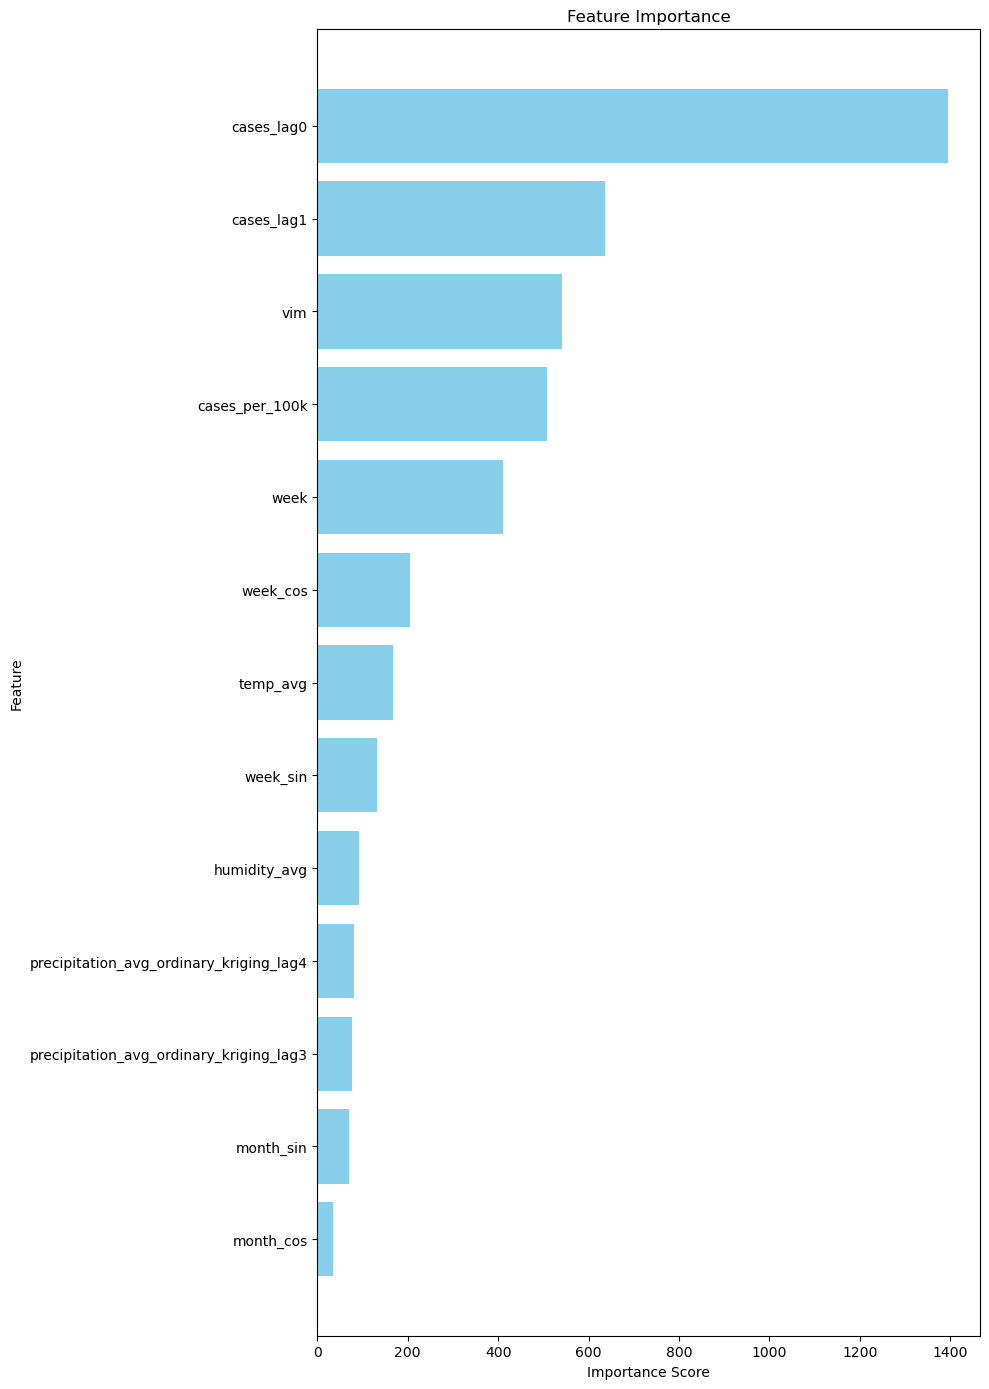

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance)

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()

RMSE: 1.5118112603037666


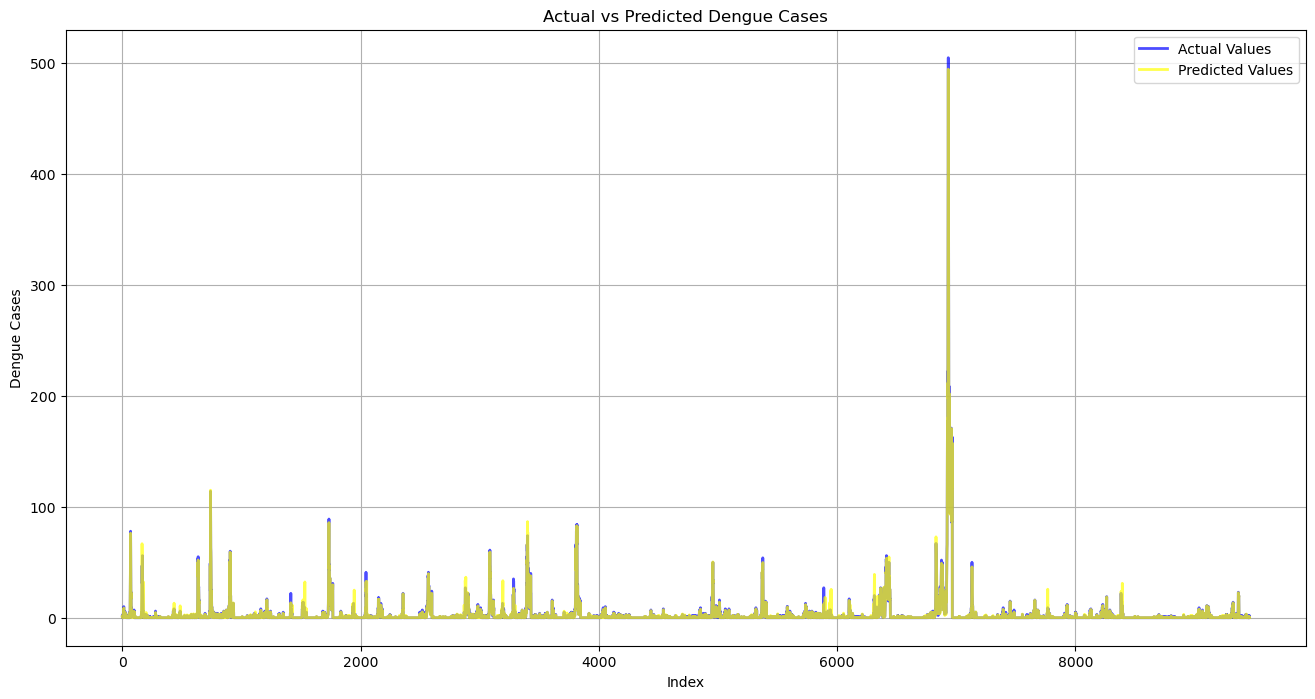

In [45]:
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse}')

# Step 2: Plot the graph
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Values', color='yellow', alpha=0.7, linewidth=2)
plt.xlabel('Index')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
import joblib

# ✅ Save the scalers and model
joblib.dump(feature_scaler, "feature_scaler.pkl")
joblib.dump(target_scaler, "target_scaler.pkl")
joblib.dump(model, "model.pkl")


['model.pkl']

In [47]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional: Get predictions on training set if not already done
train_scaled_predictions = model.predict(X_train, num_iteration=model.best_iteration)
y_train_pred = target_scaler.inverse_transform(train_scaled_predictions.reshape(-1, 1))
y_train_pred = np.clip(y_train_pred, 0, None)
y_train = target_scaler.inverse_transform(y_train)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
test_mae = mean_absolute_error(y_actual, y_pred)
test_r2 = r2_score(y_actual, y_pred)

# ===== Create Evaluation Summary Table =====
evaluation_results = {
    '': ['Global - Train', 'Global - Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae],
    'R²': [train_r2, test_r2]
}

results_df = pd.DataFrame(evaluation_results)
print("\n===== Evaluation Metrics Table =====")
print(results_df.to_string(index=False))


===== Evaluation Metrics Table =====
                    RMSE      MAE       R²
Global - Train 58.335964 2.274612 0.936512
 Global - Test  1.511811 0.397166 0.990482



City: angra dos reis, RMSE: 0.6036370195789527


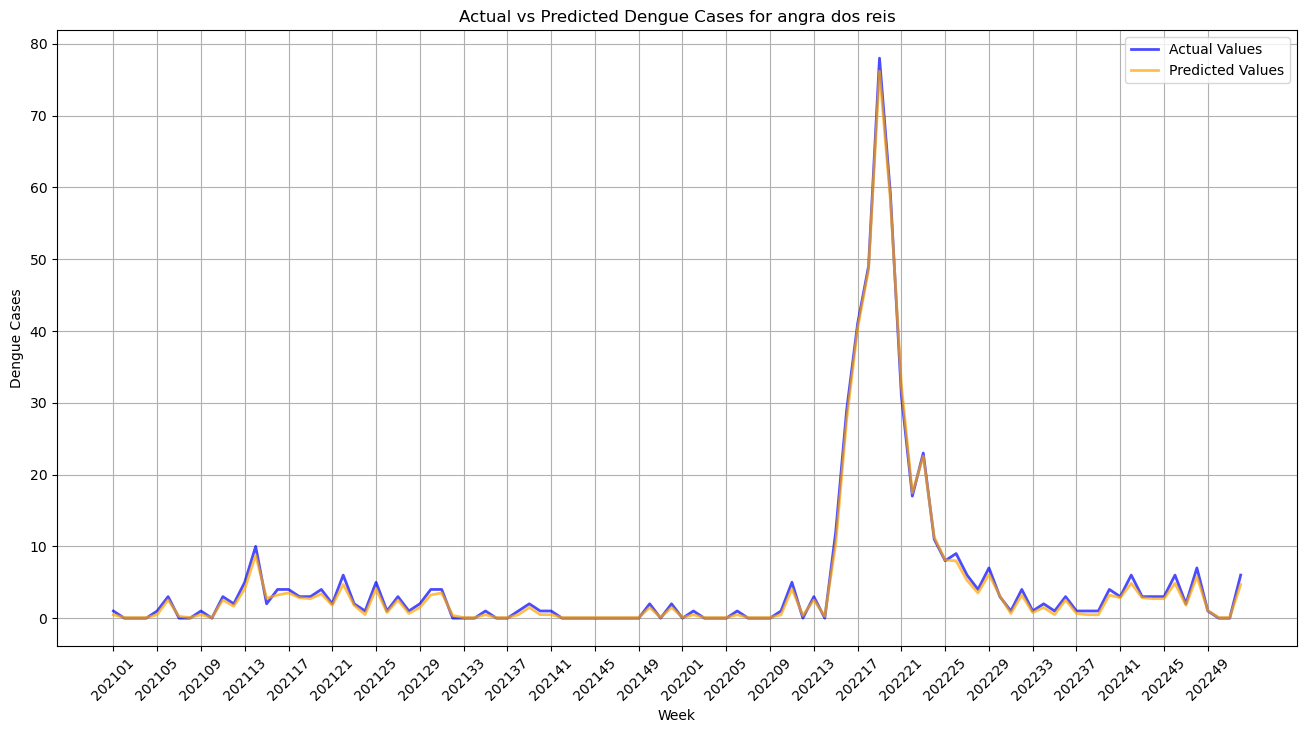


City: aperibé, RMSE: 6.386931664598877


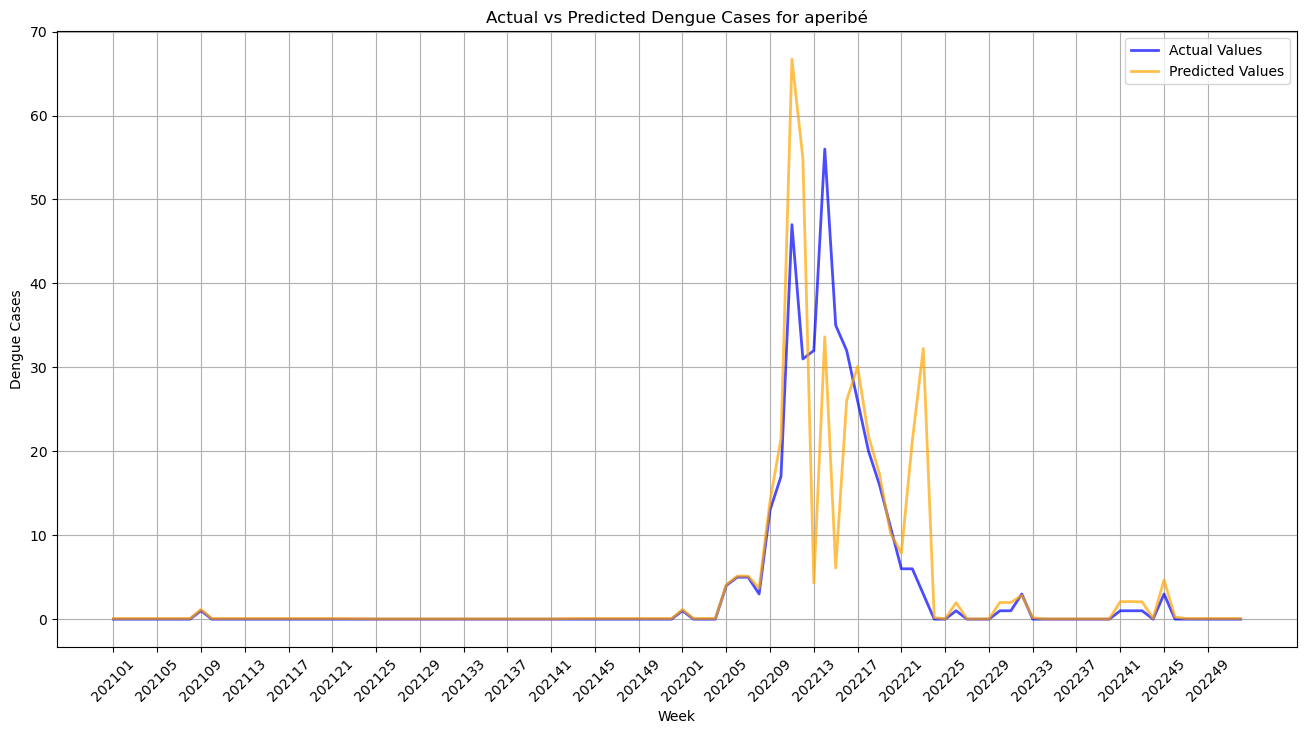


City: barra do piraí, RMSE: 0.6139524026482948


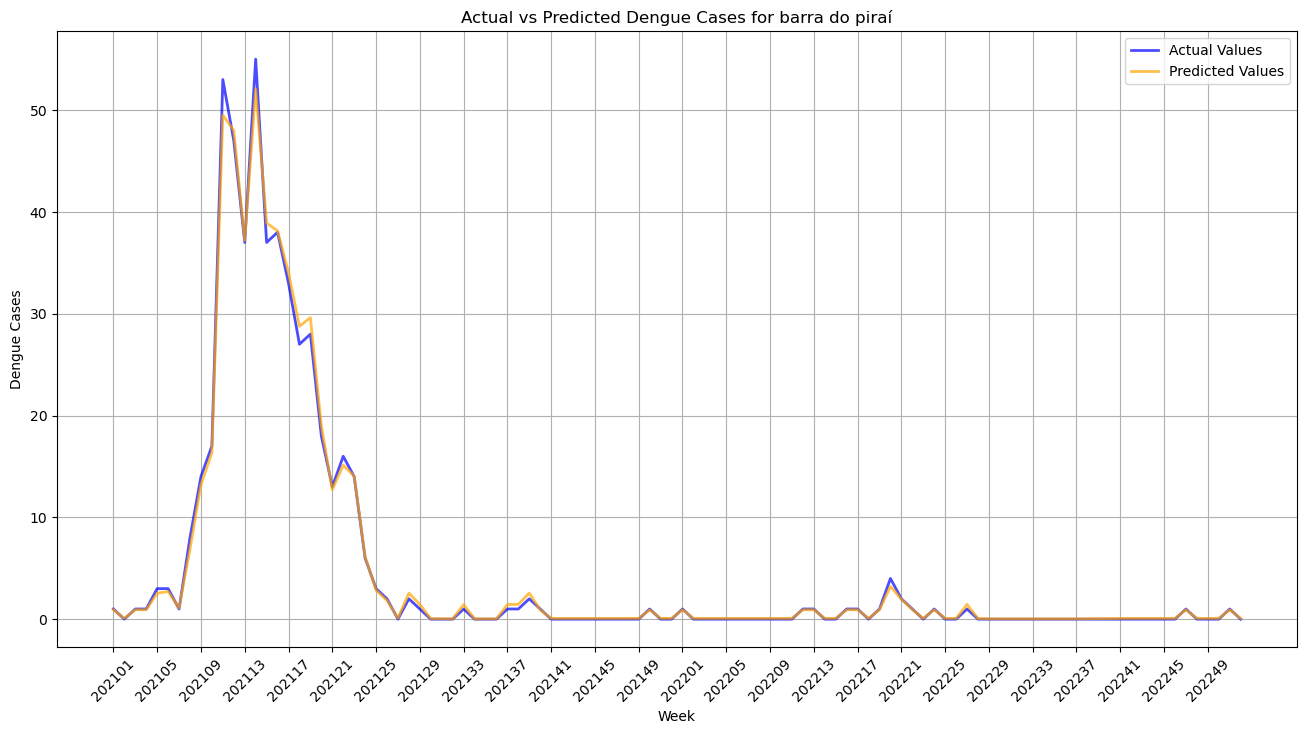


City: barra mansa, RMSE: 0.7556423293819444


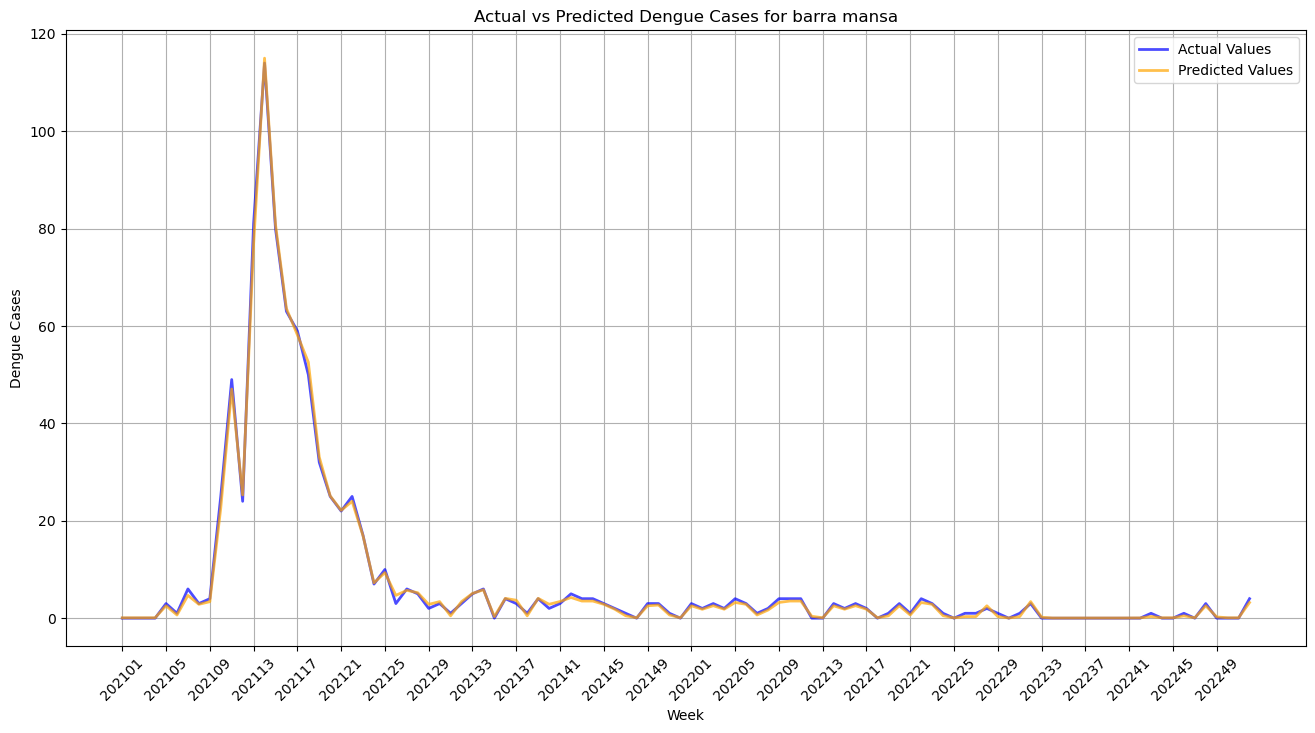


City: belford roxo, RMSE: 0.8786762624505249


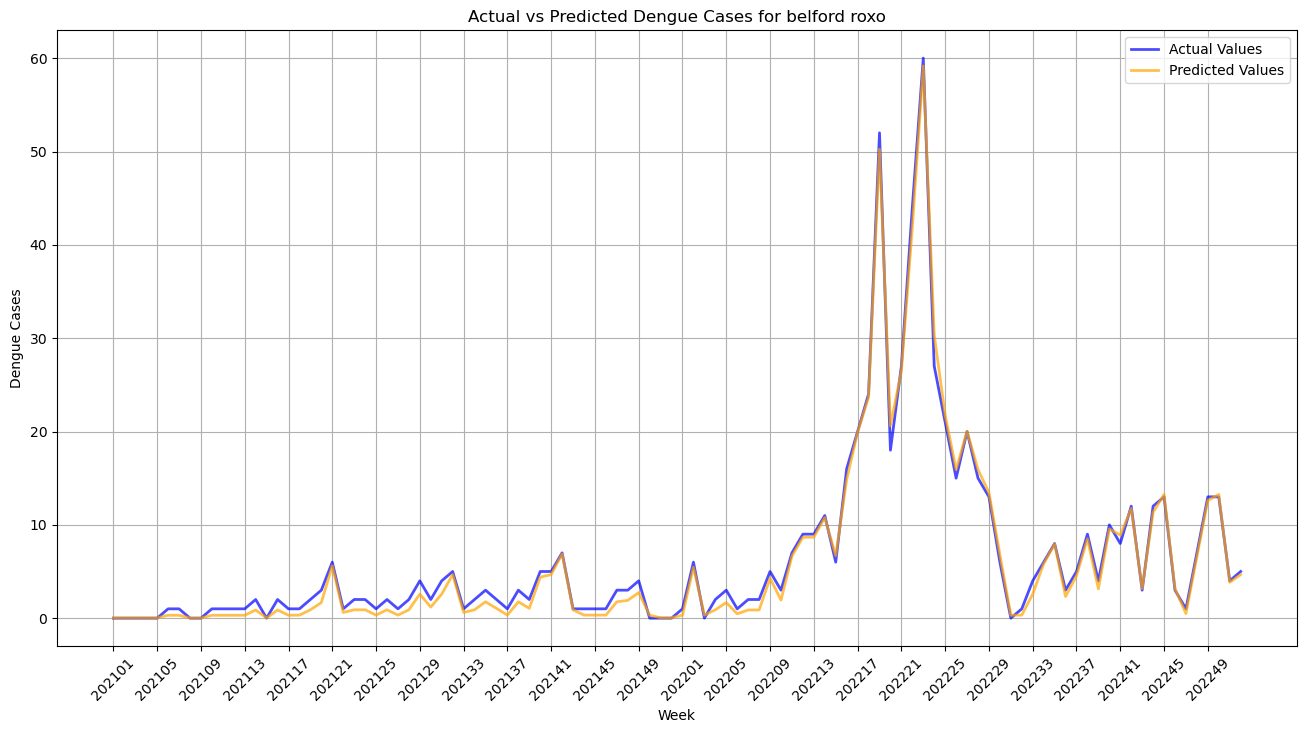


City: cabo frio, RMSE: 0.45561965759872325


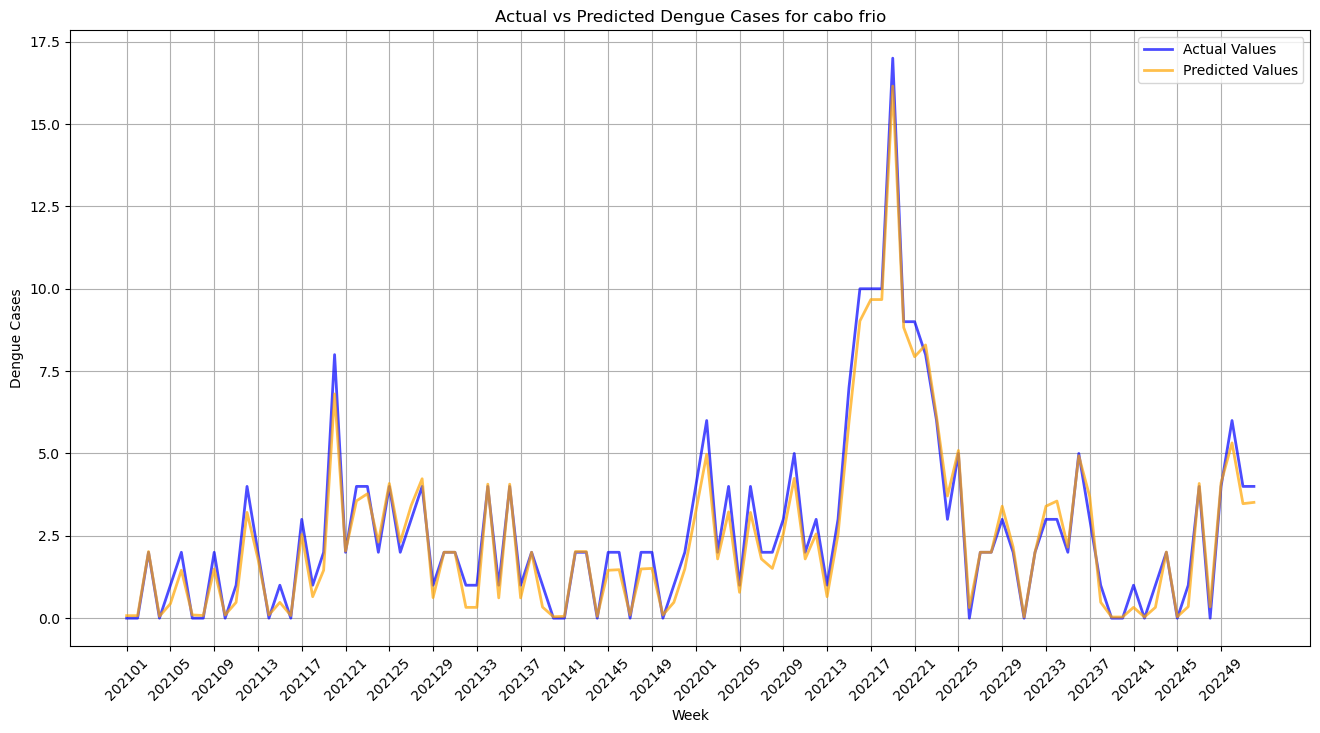


City: cambuci, RMSE: 1.379809954714597


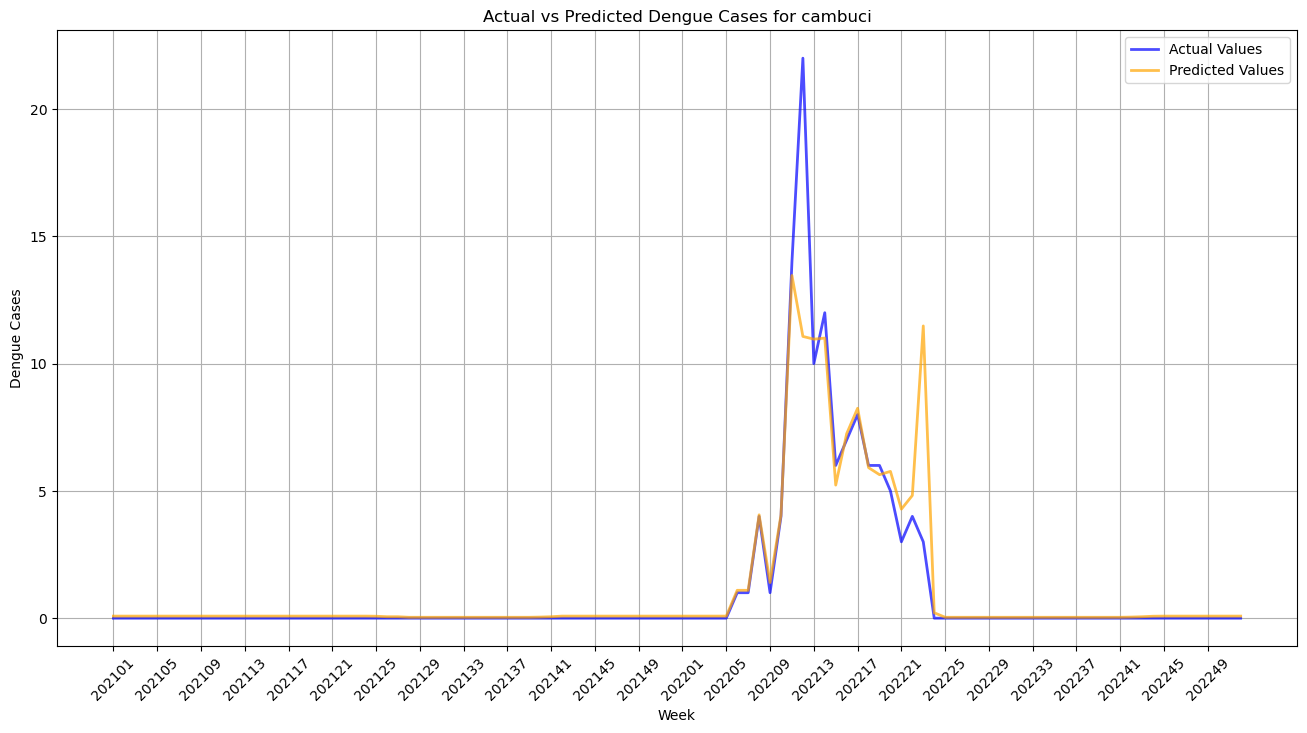


City: carapebus, RMSE: 4.016882529946217


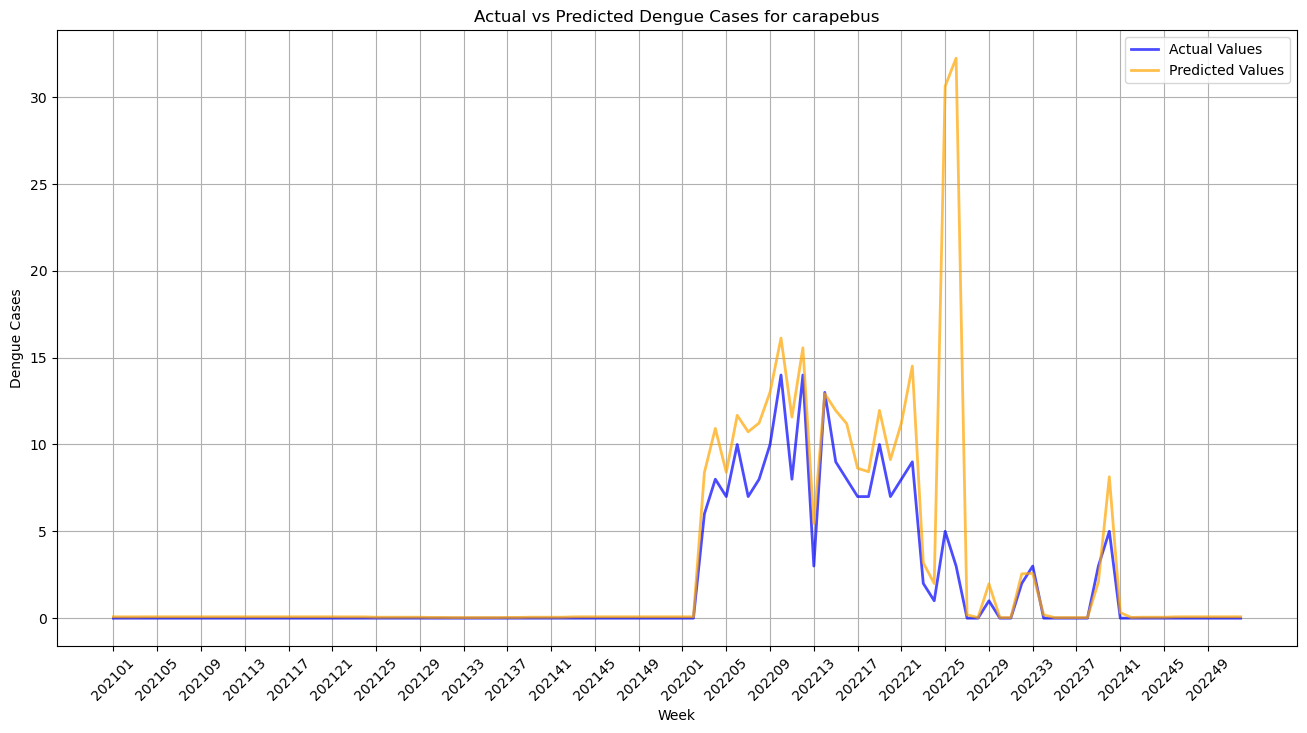


City: campos dos goytacazes, RMSE: 0.9912671970394016


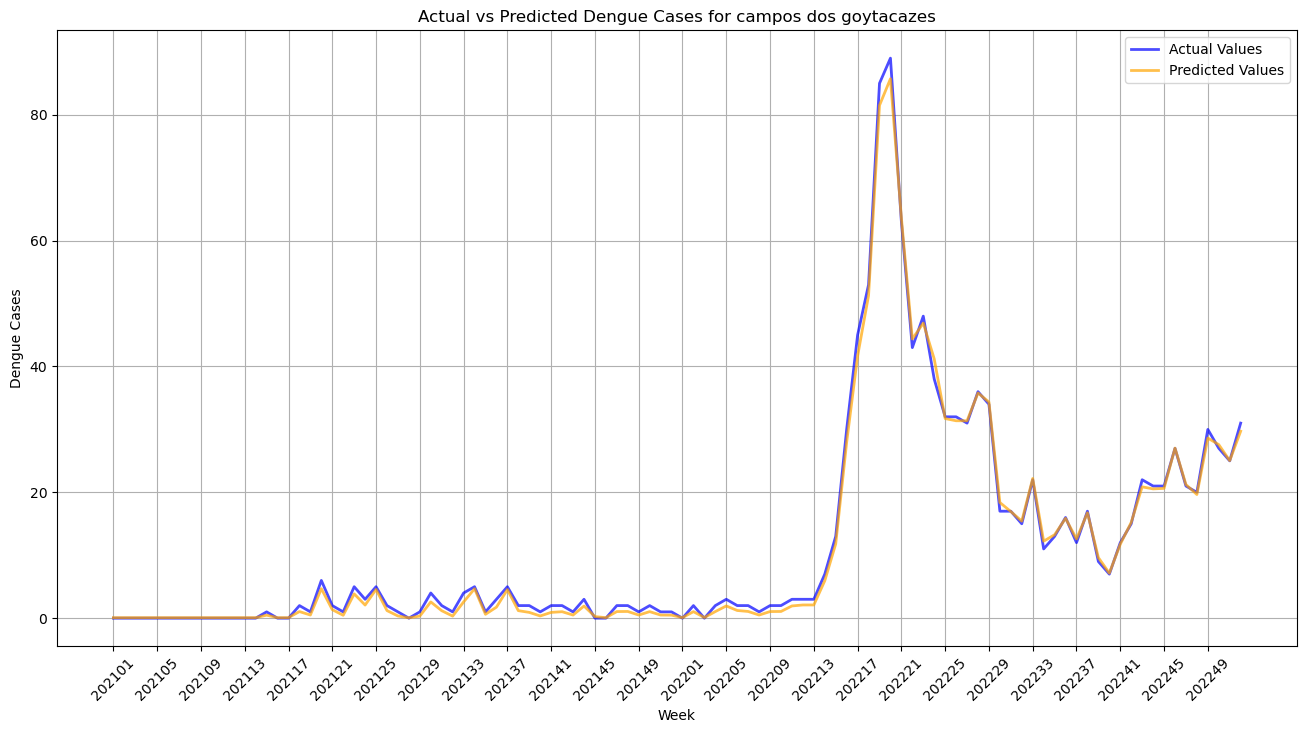


City: cardoso moreira, RMSE: 2.6603892339575186


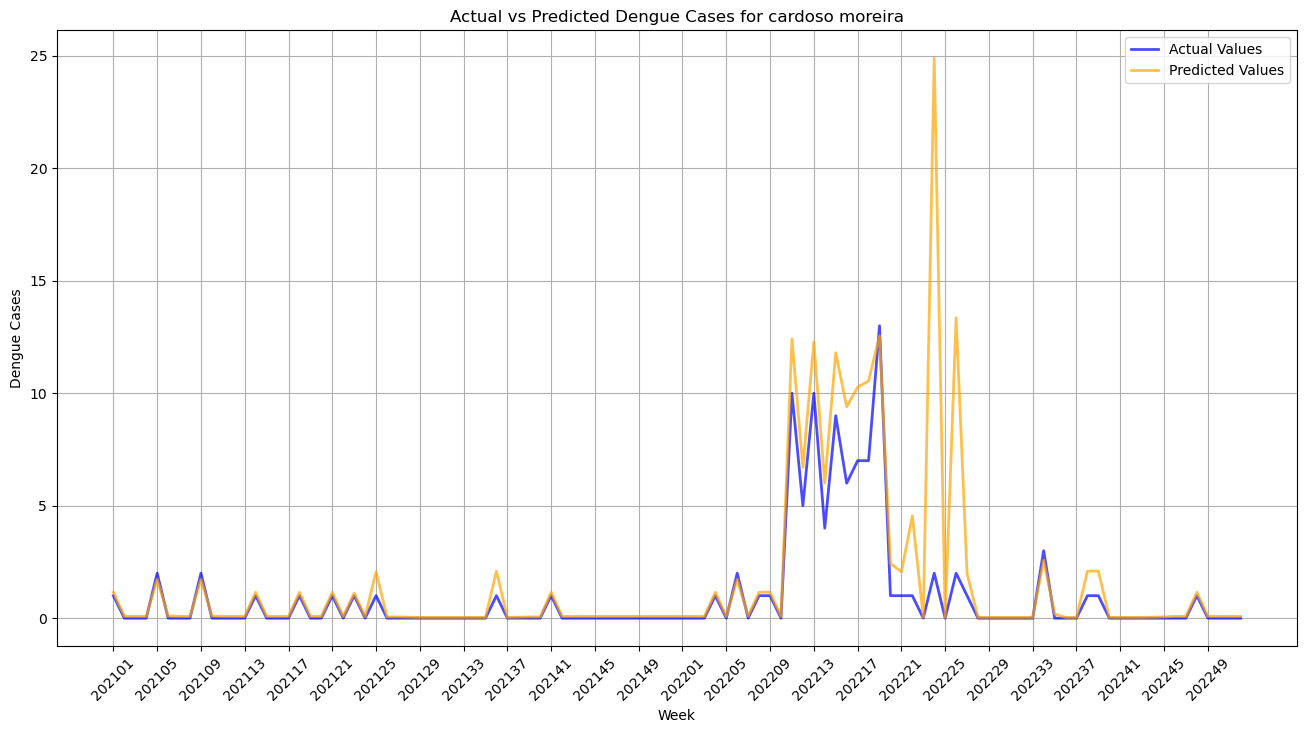


City: carmo, RMSE: 3.7231237510421282


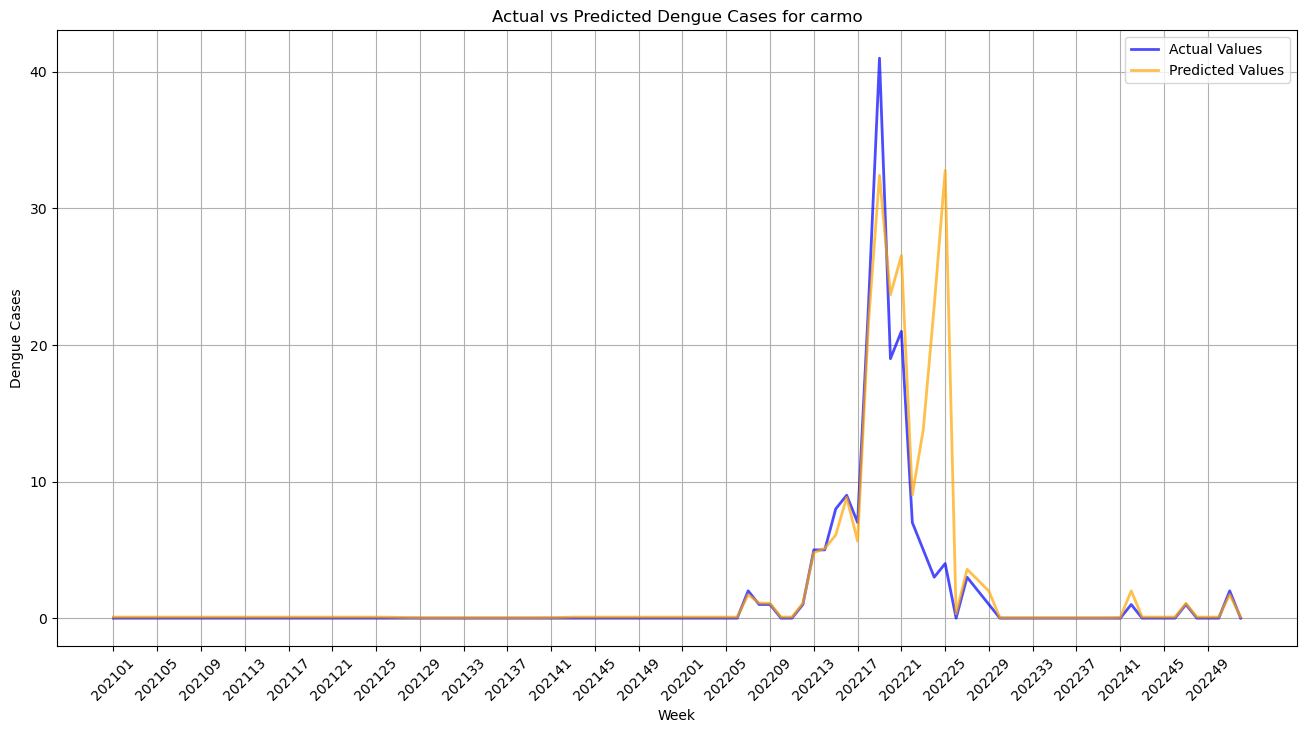


City: casimiro de abreu, RMSE: 0.4291805346343948


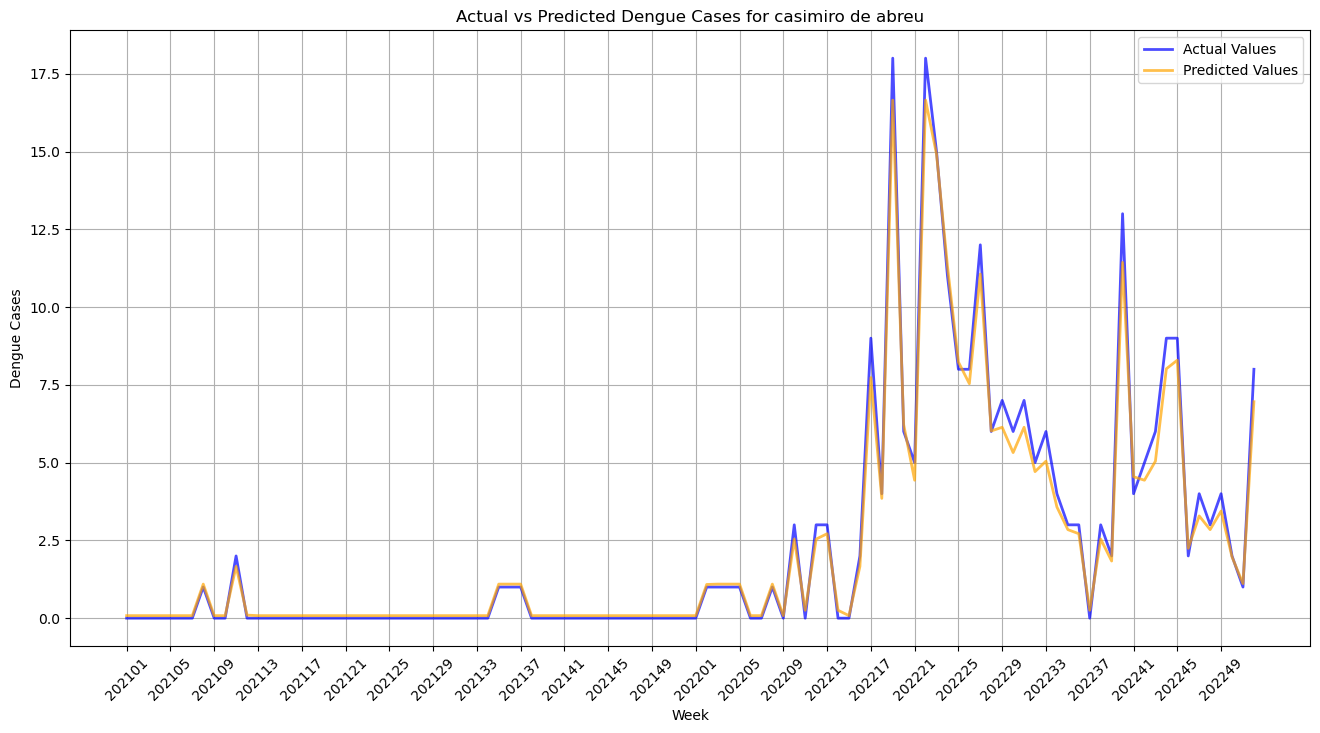


City: cordeiro, RMSE: 0.3780002197893927


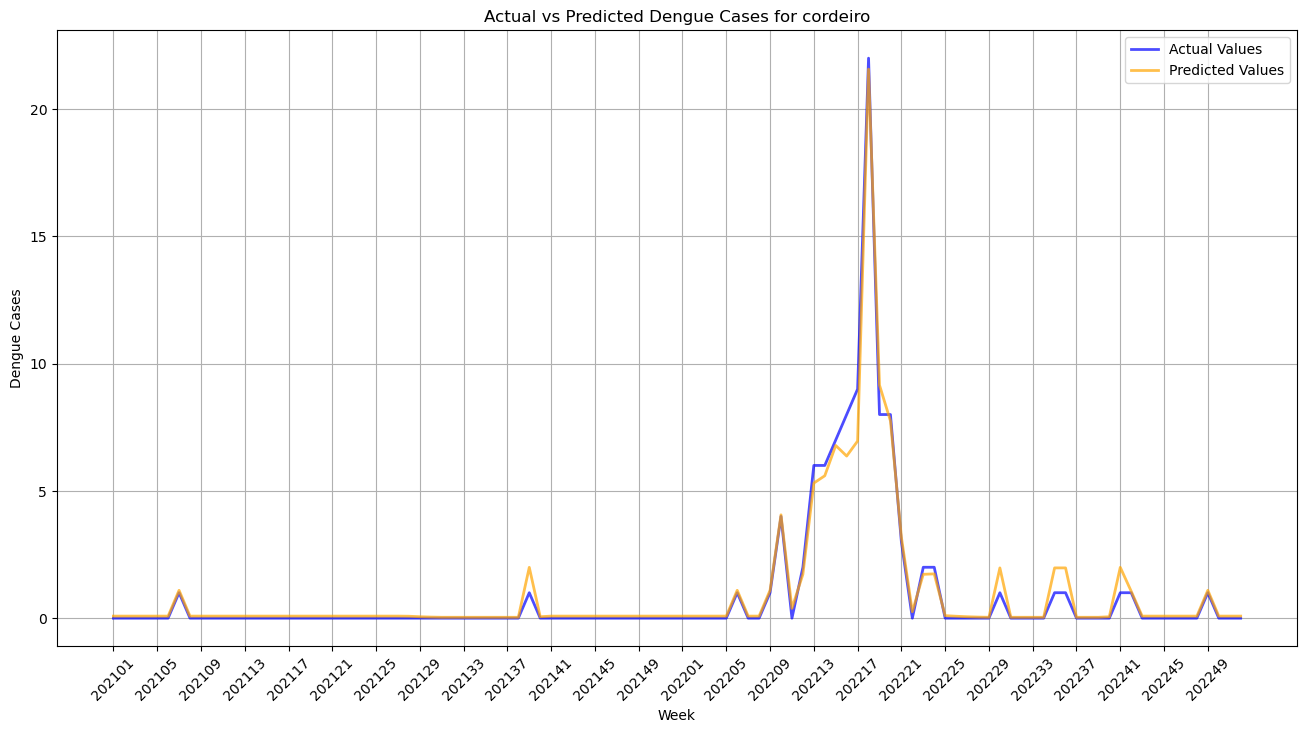


City: duque de caxias, RMSE: 0.9009473145911935


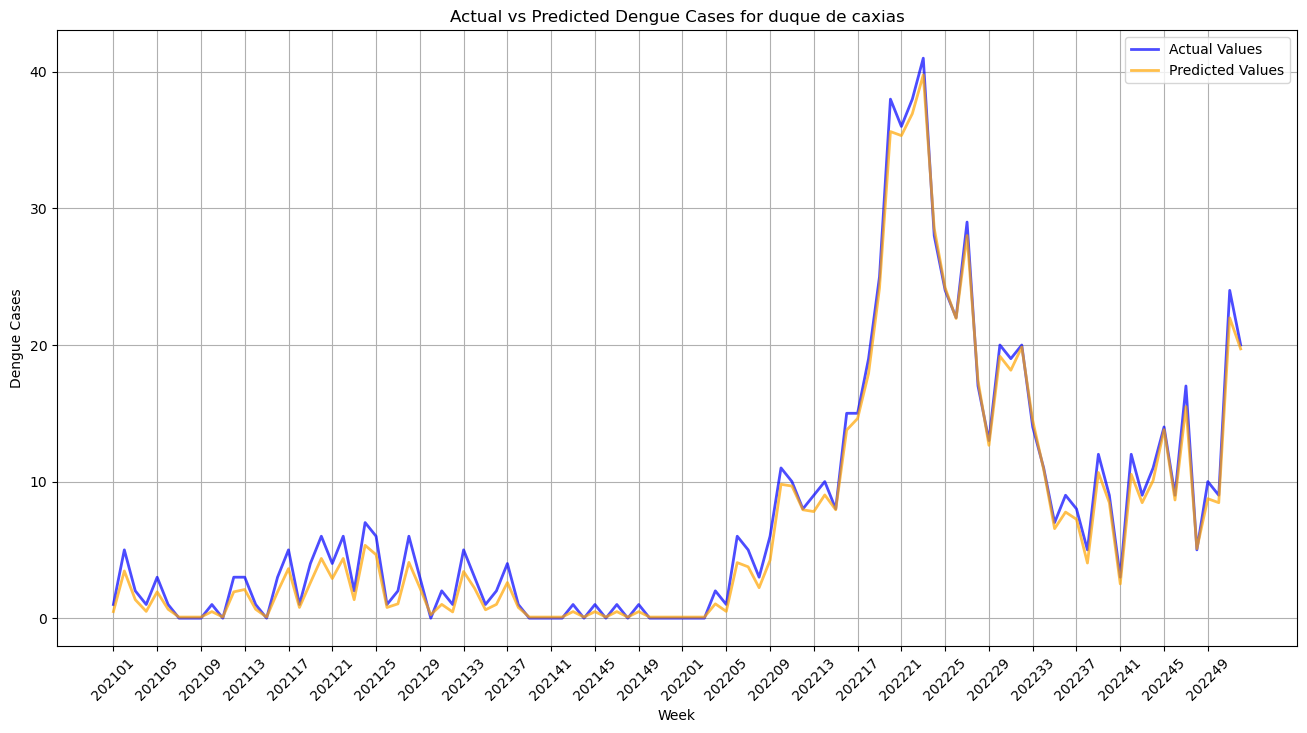


City: iguaba grande, RMSE: 4.608090735559667


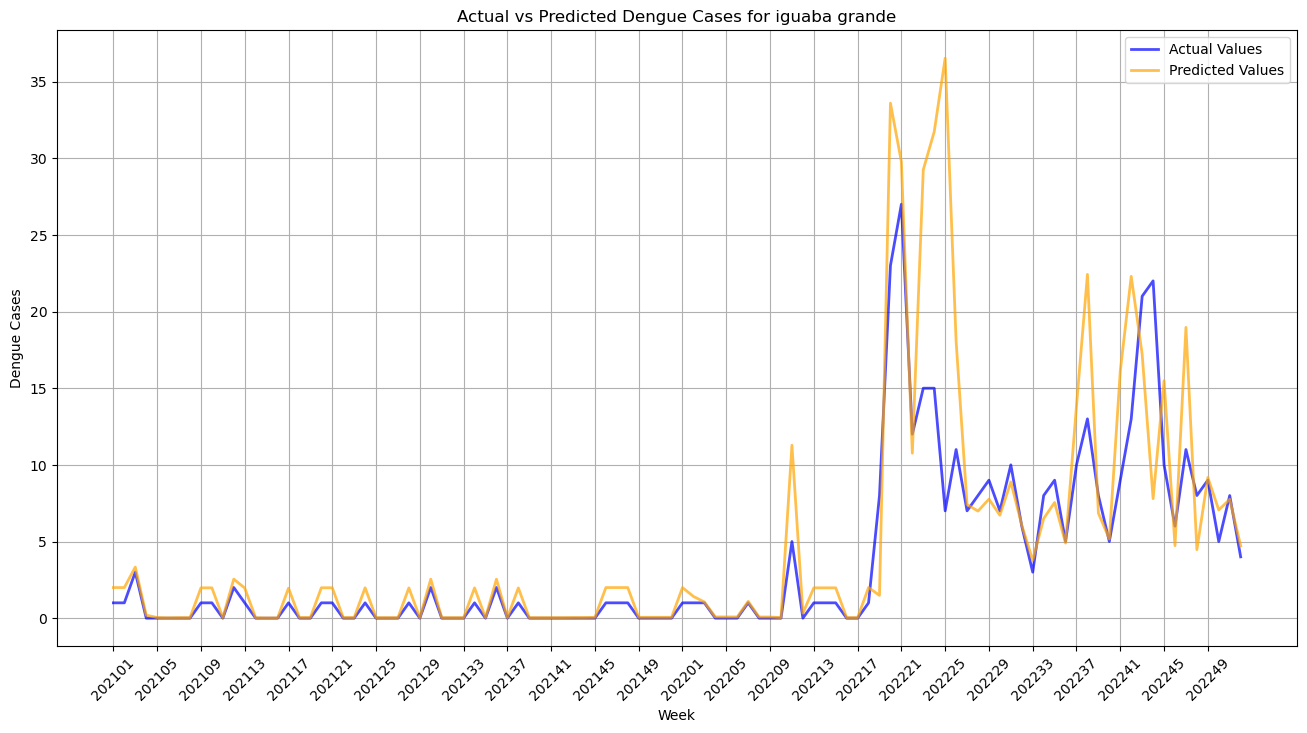


City: itaboraí, RMSE: 0.5006098548418298


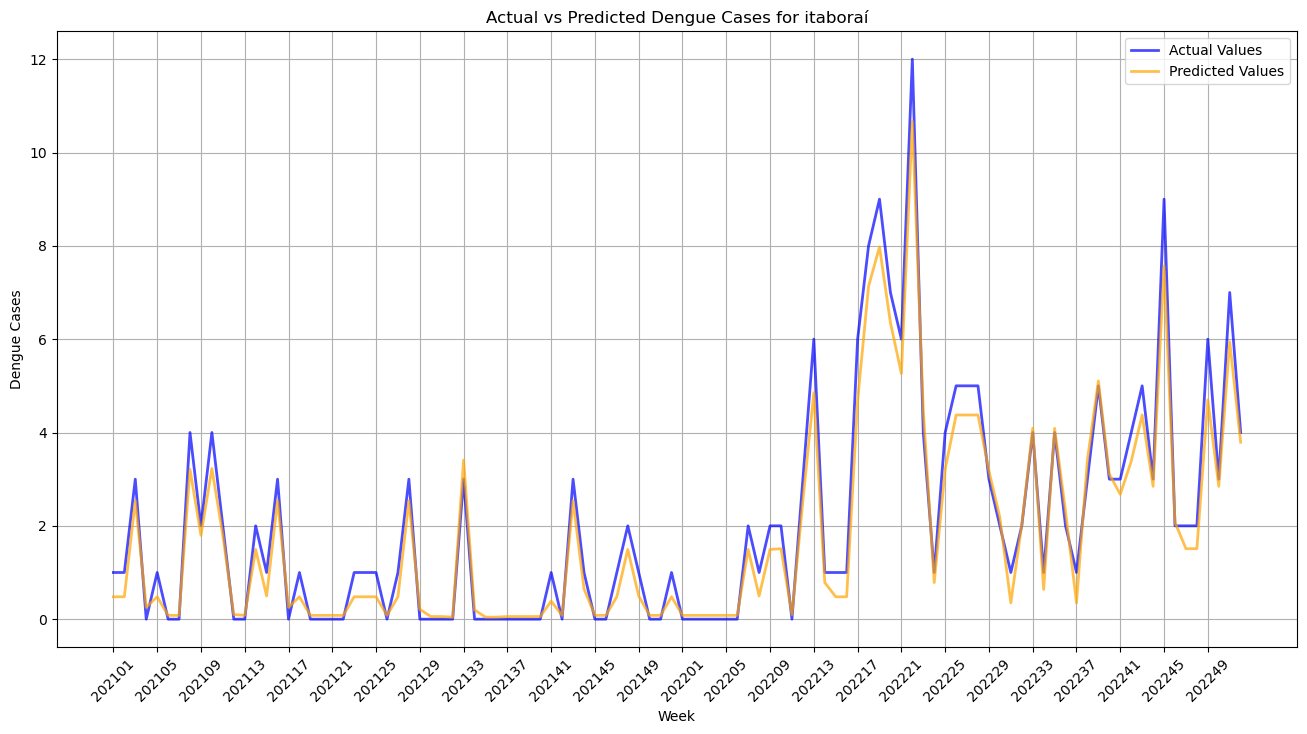


City: itaguaí, RMSE: 0.581346105666077


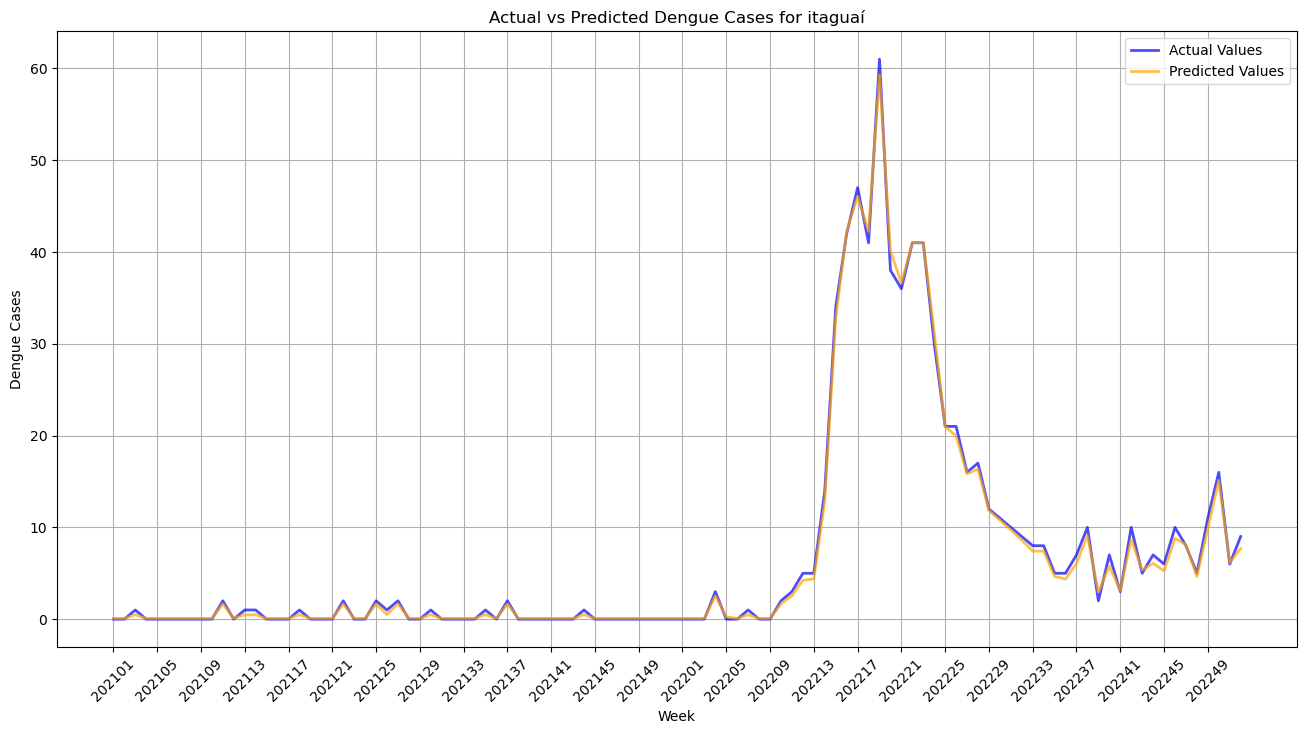


City: italva, RMSE: 3.8366629247797936


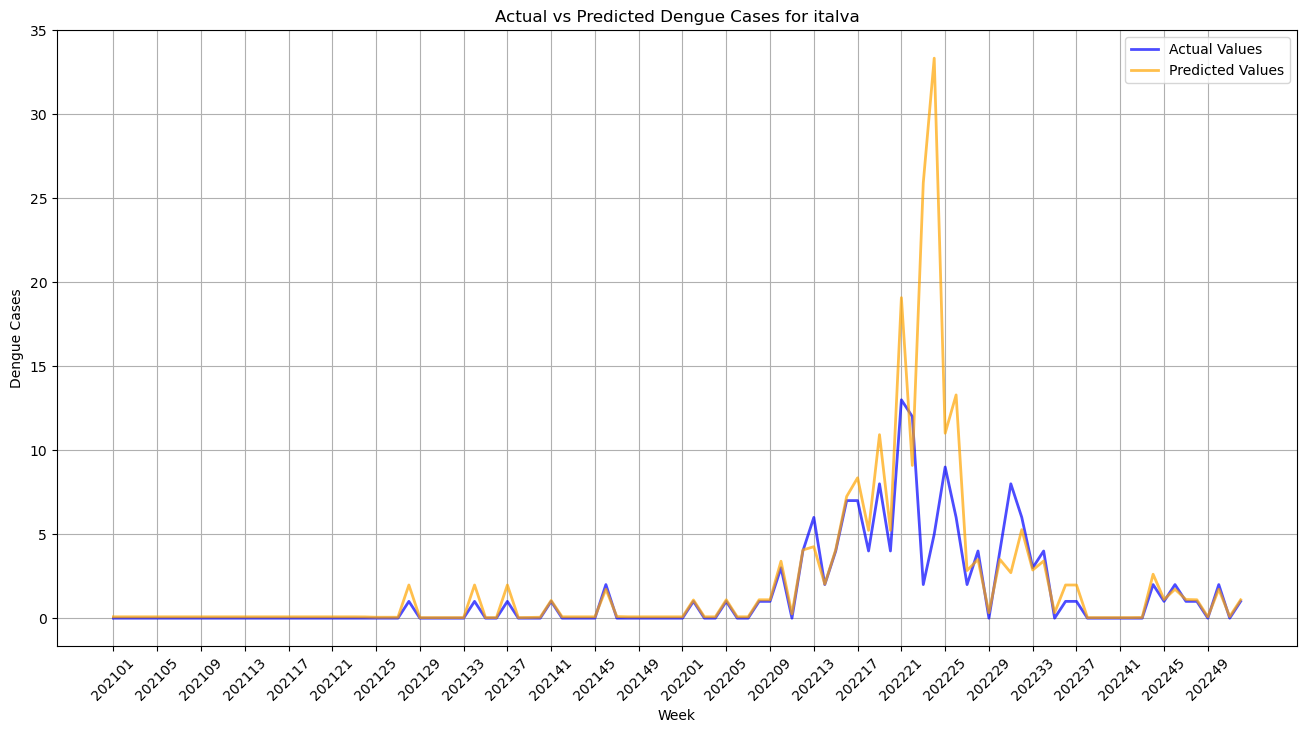


City: itaocara, RMSE: 1.8132747967761065


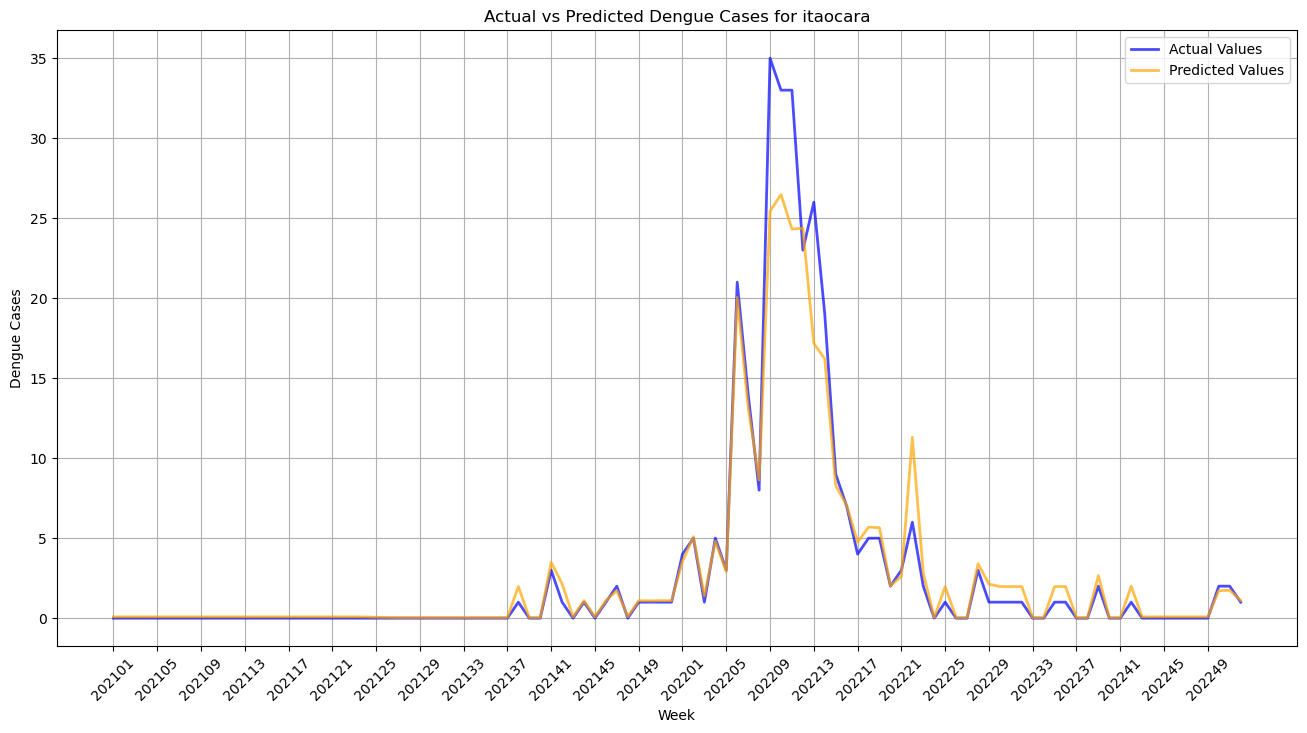


City: itaperuna, RMSE: 3.3366410982177697


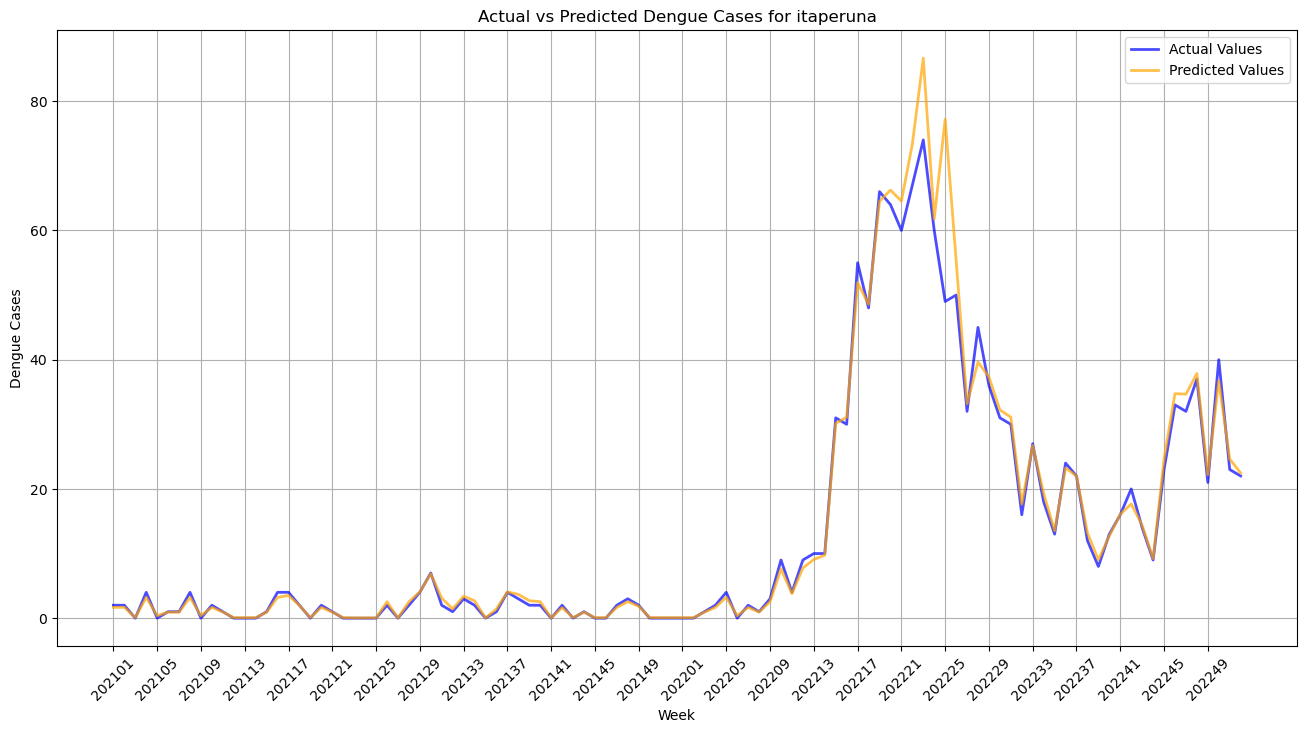


City: japeri, RMSE: 0.3735778529947687


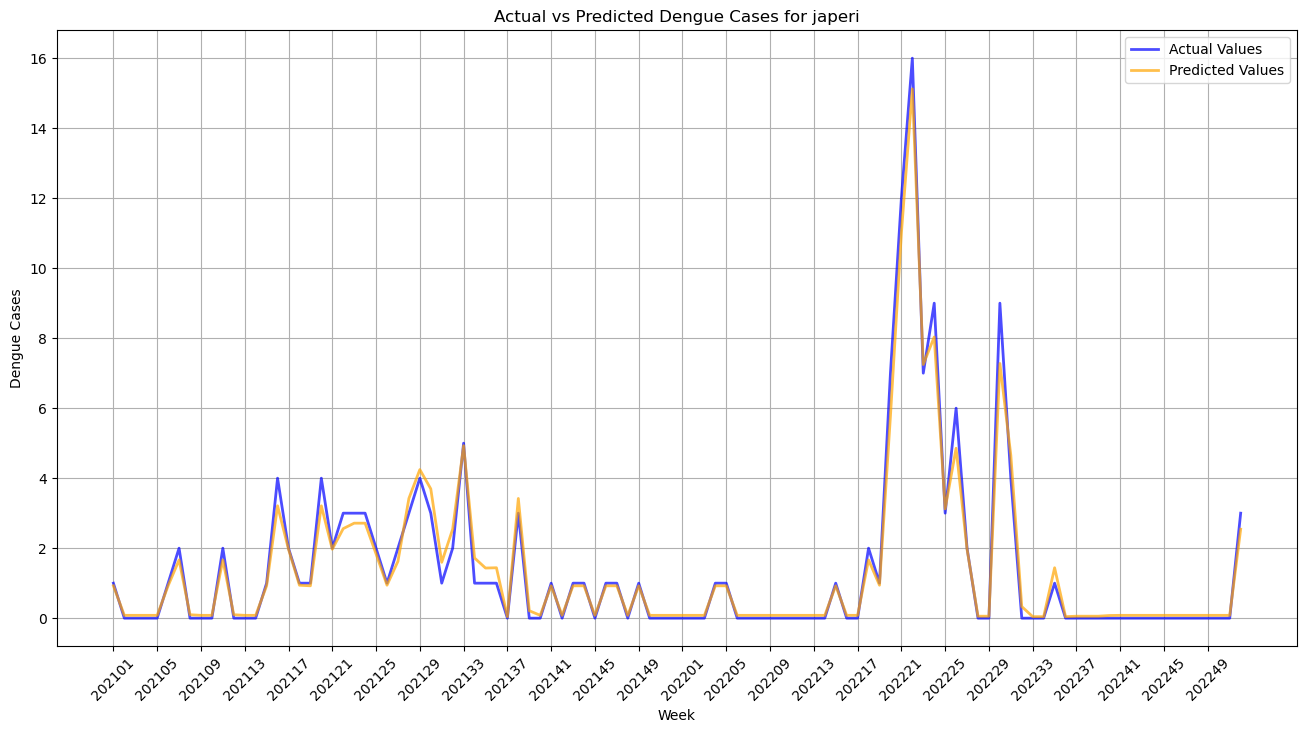


City: macaé, RMSE: 0.8508094430580347


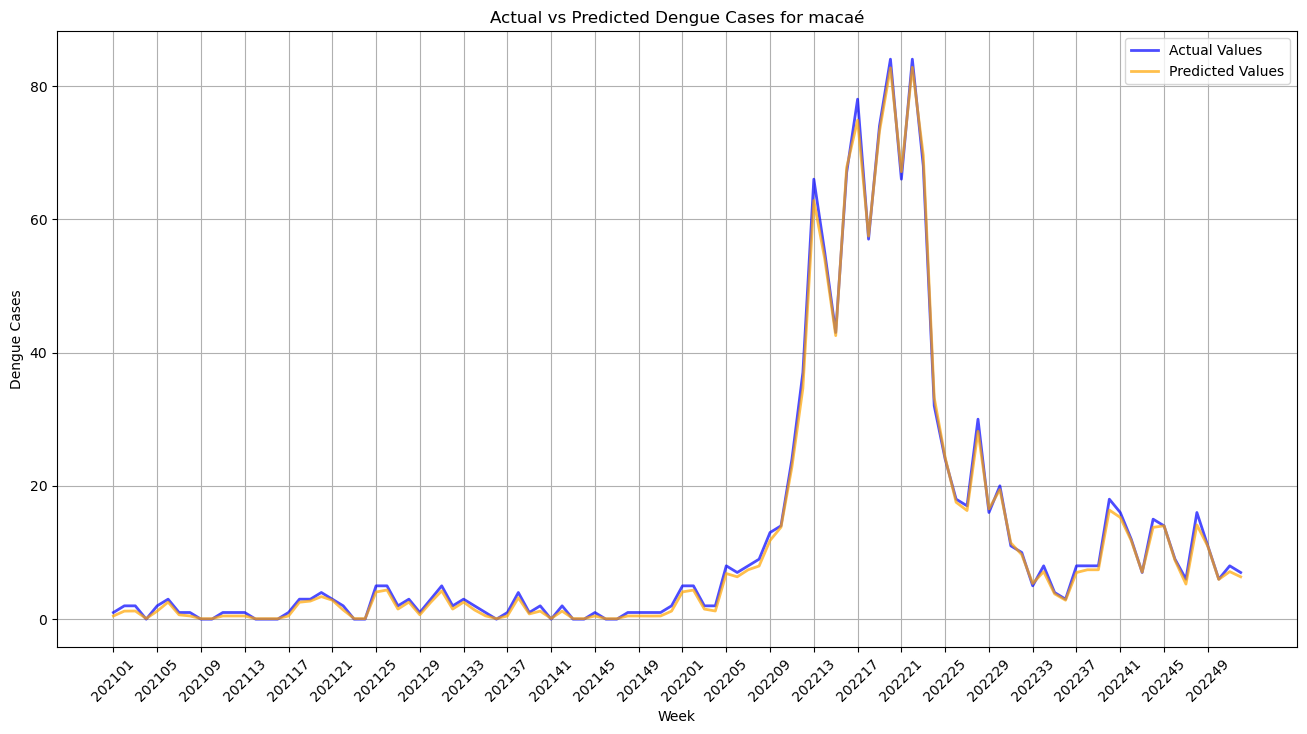


City: magé, RMSE: 0.4166436574595613


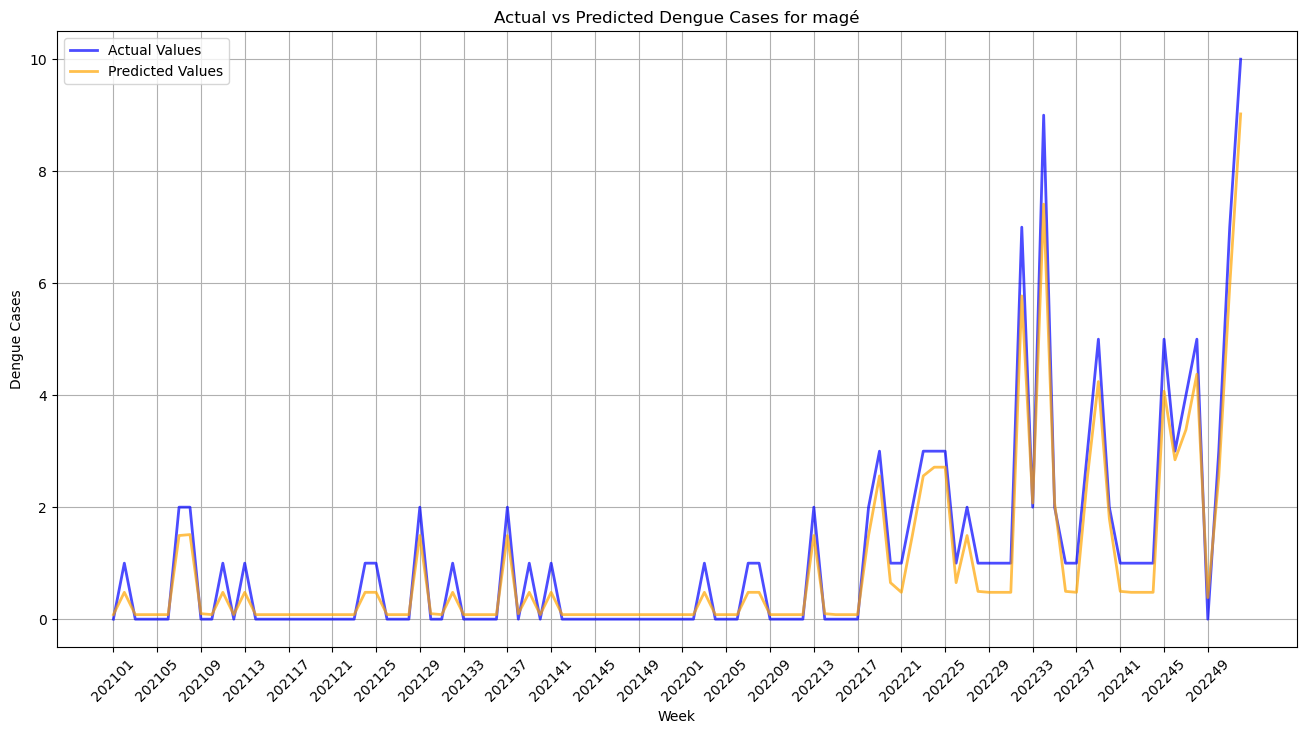


City: nova friburgo, RMSE: 0.5403394754242602


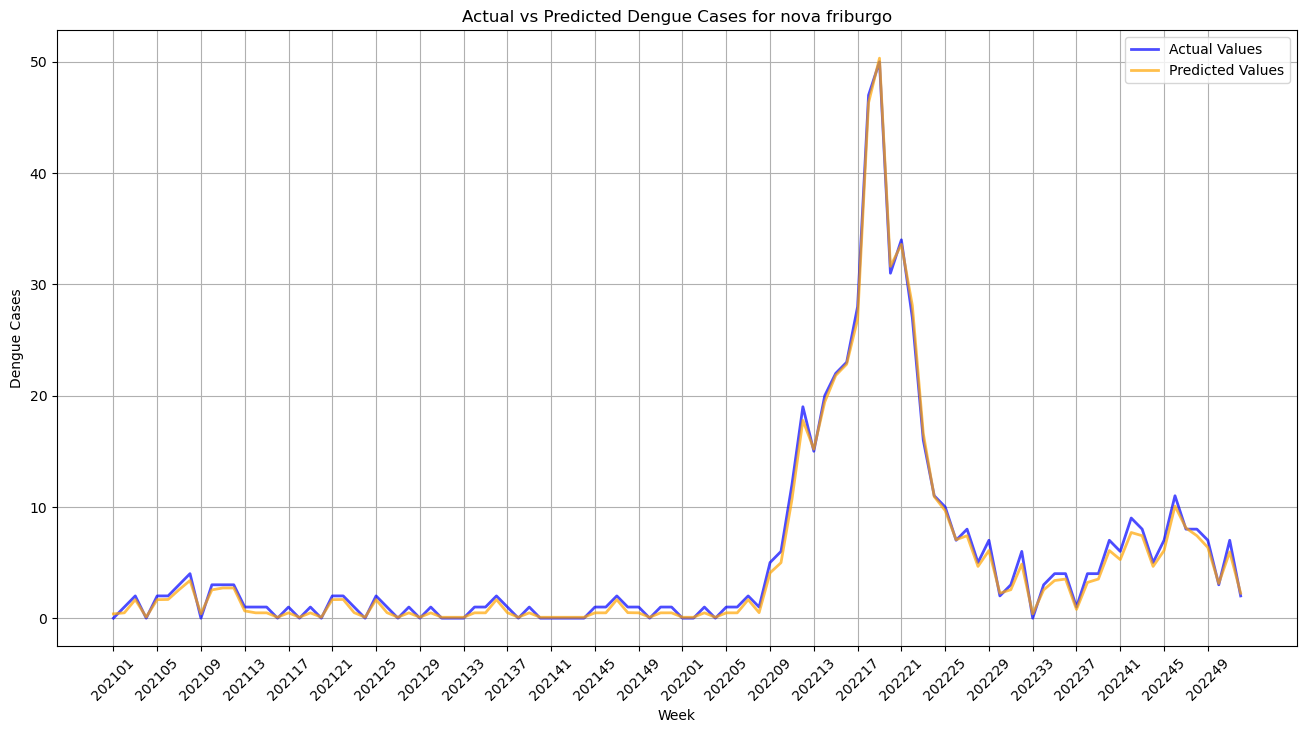


City: nova iguaçu, RMSE: 0.9037620217454625


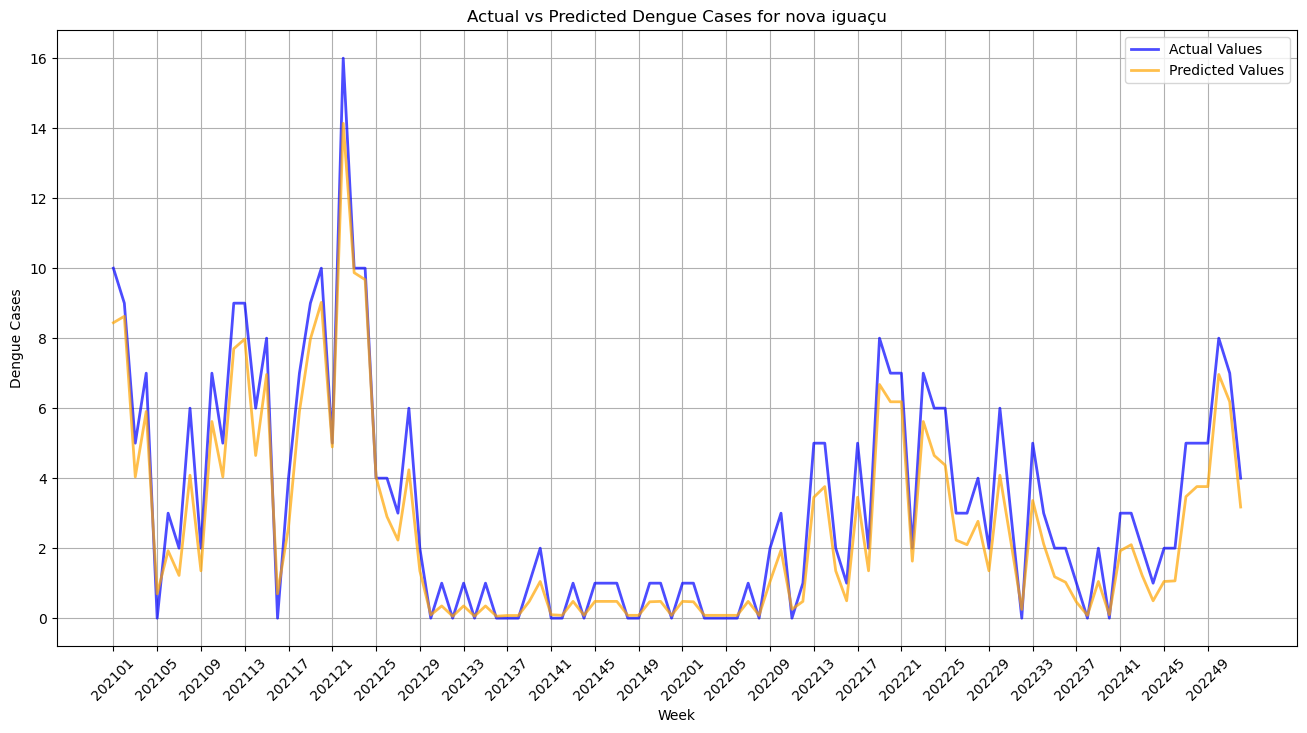


City: paraty, RMSE: 0.9037505139538413


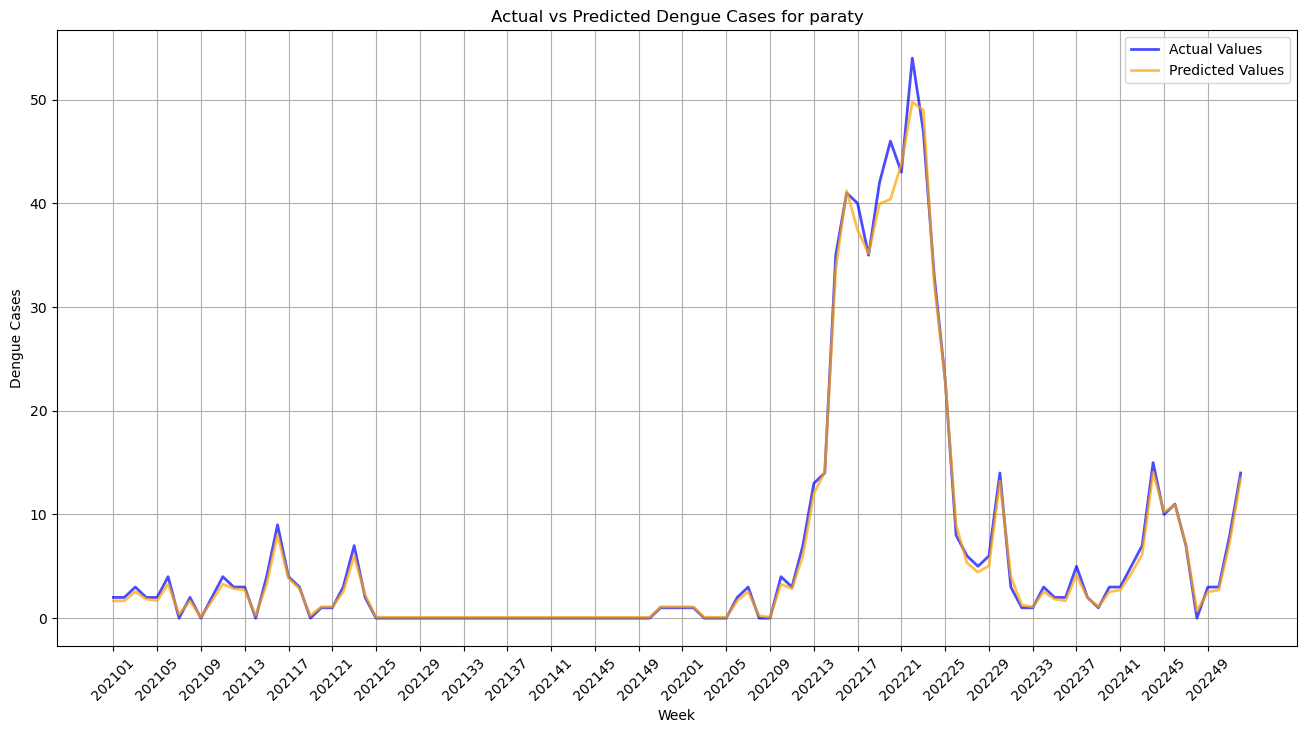


City: petrópolis, RMSE: 0.4875665736611881


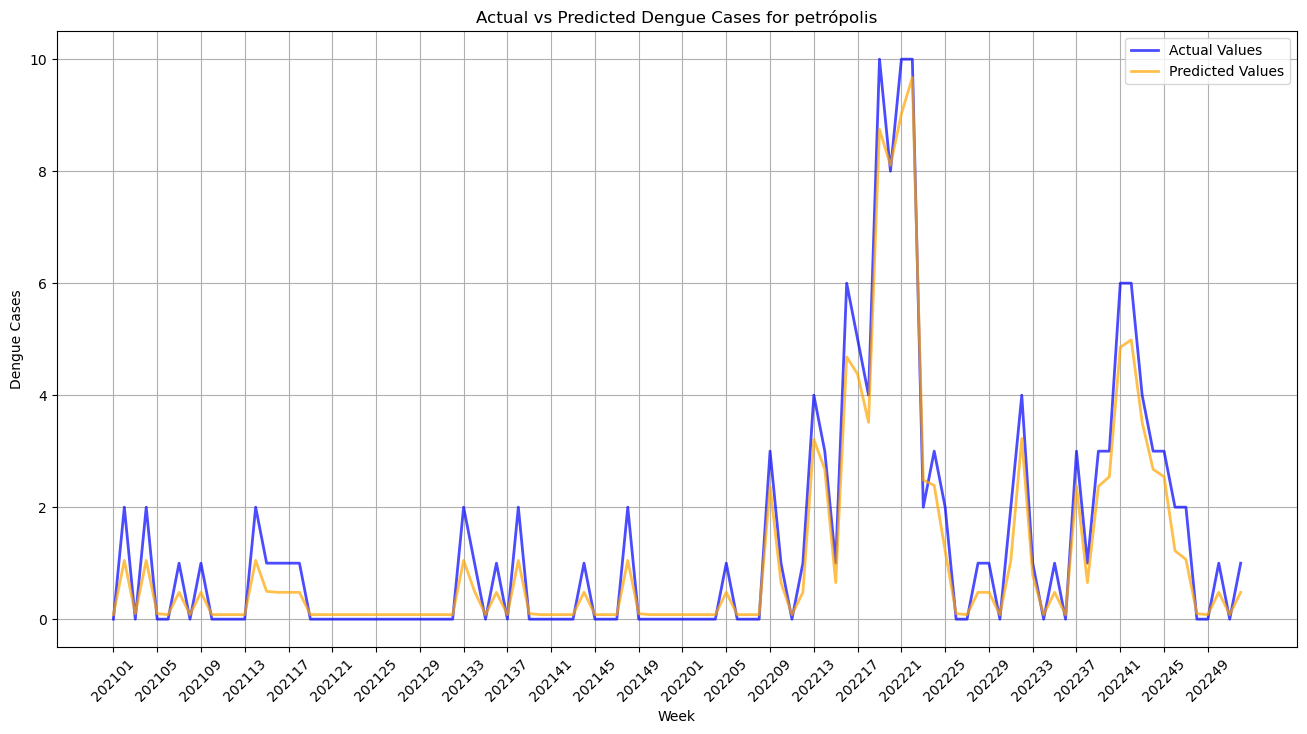


City: piraí, RMSE: 0.41629836934500214


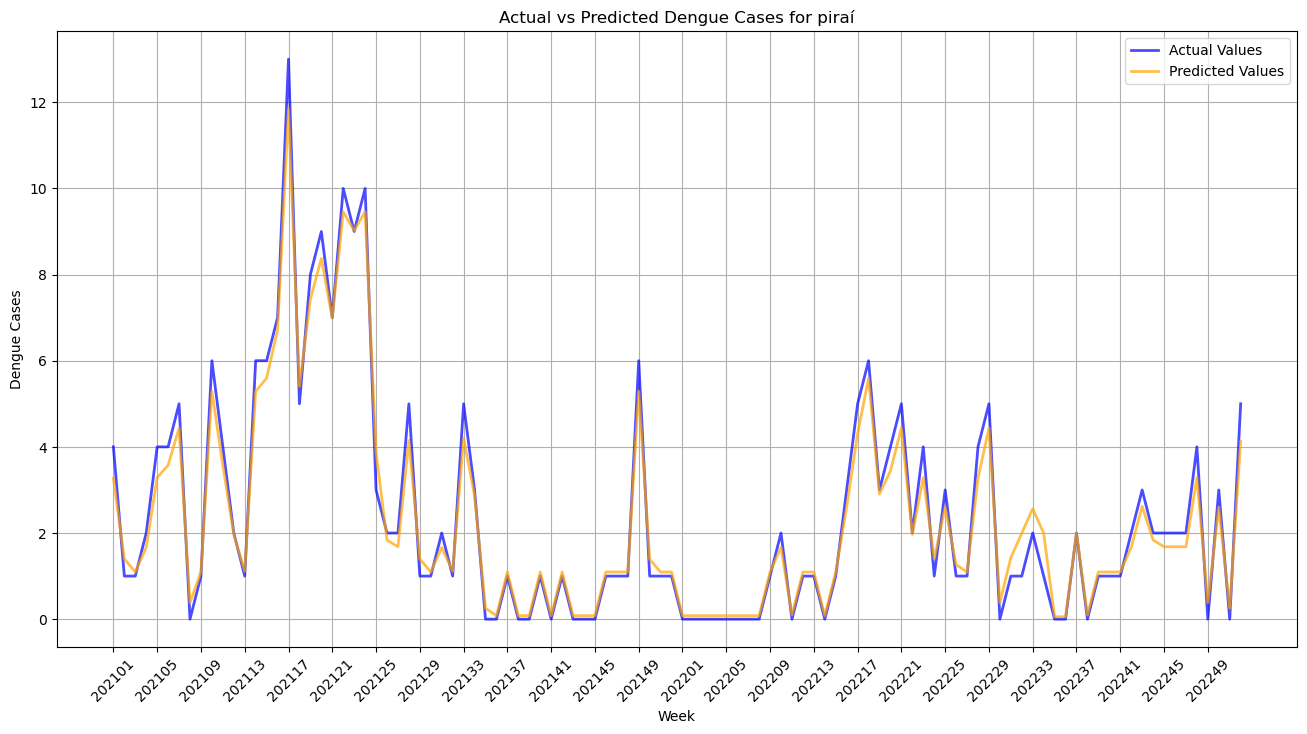


City: porciúncula, RMSE: 2.5804625429180224


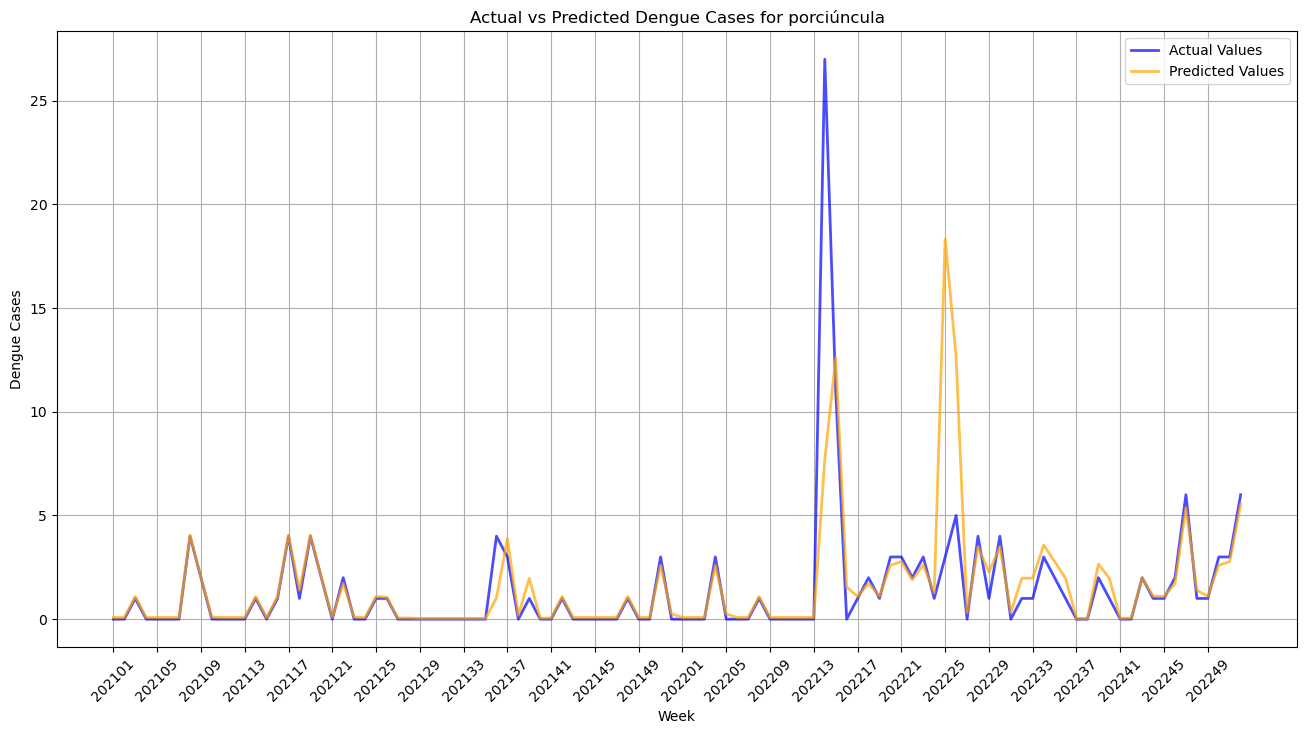


City: quatis, RMSE: 1.1734397922651516


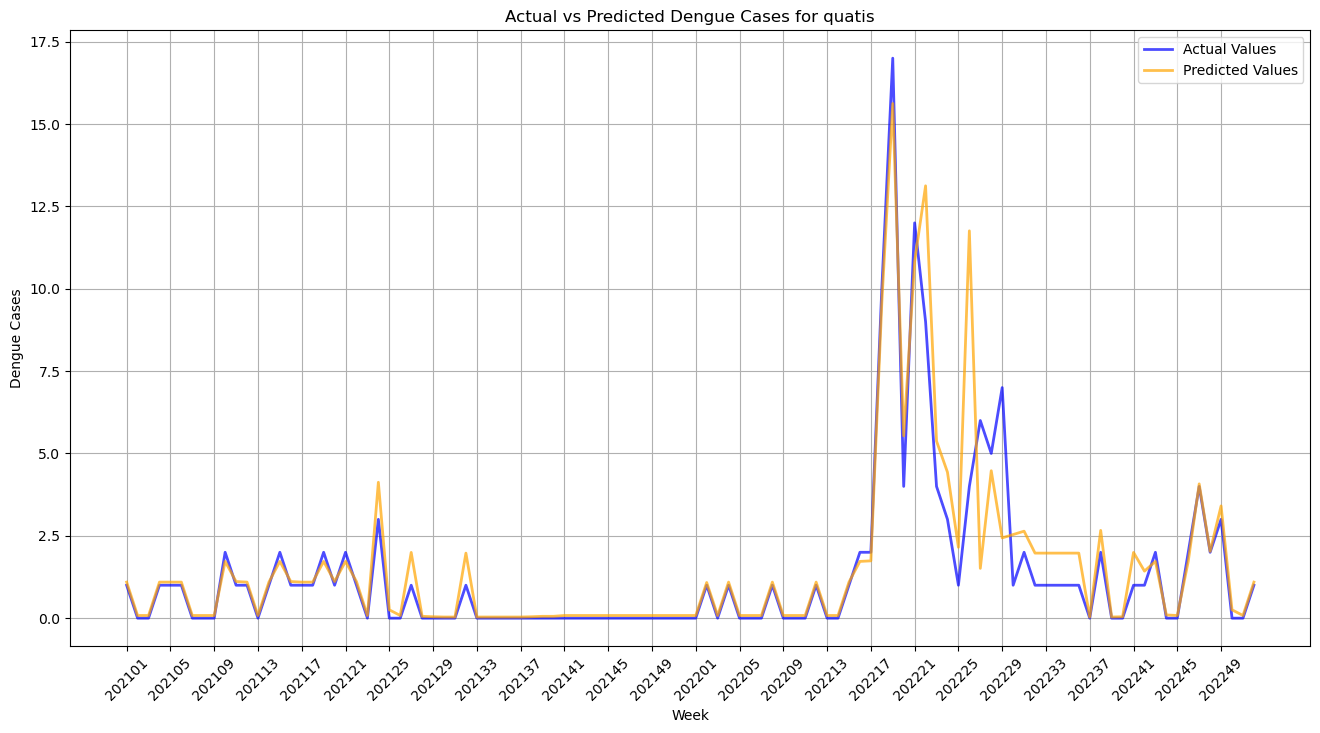


City: quissamã, RMSE: 3.569461759504911


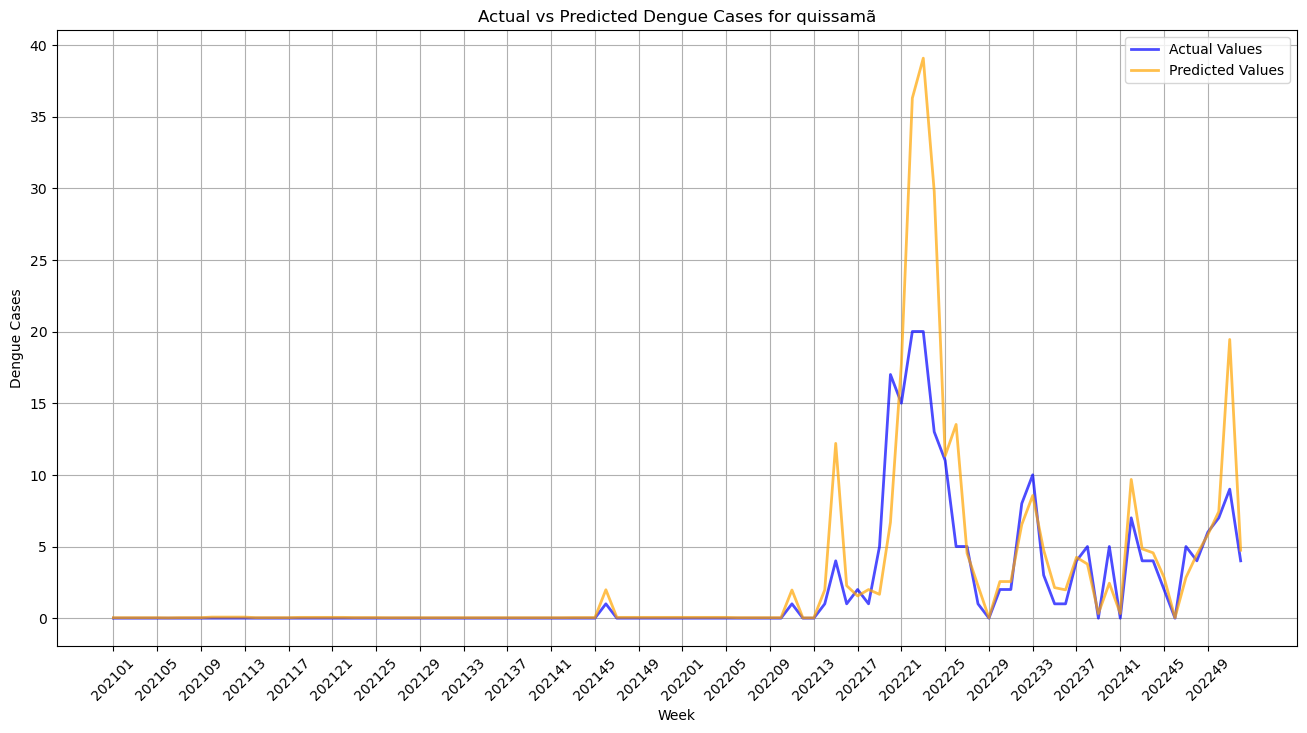


City: resende, RMSE: 1.330508879383286


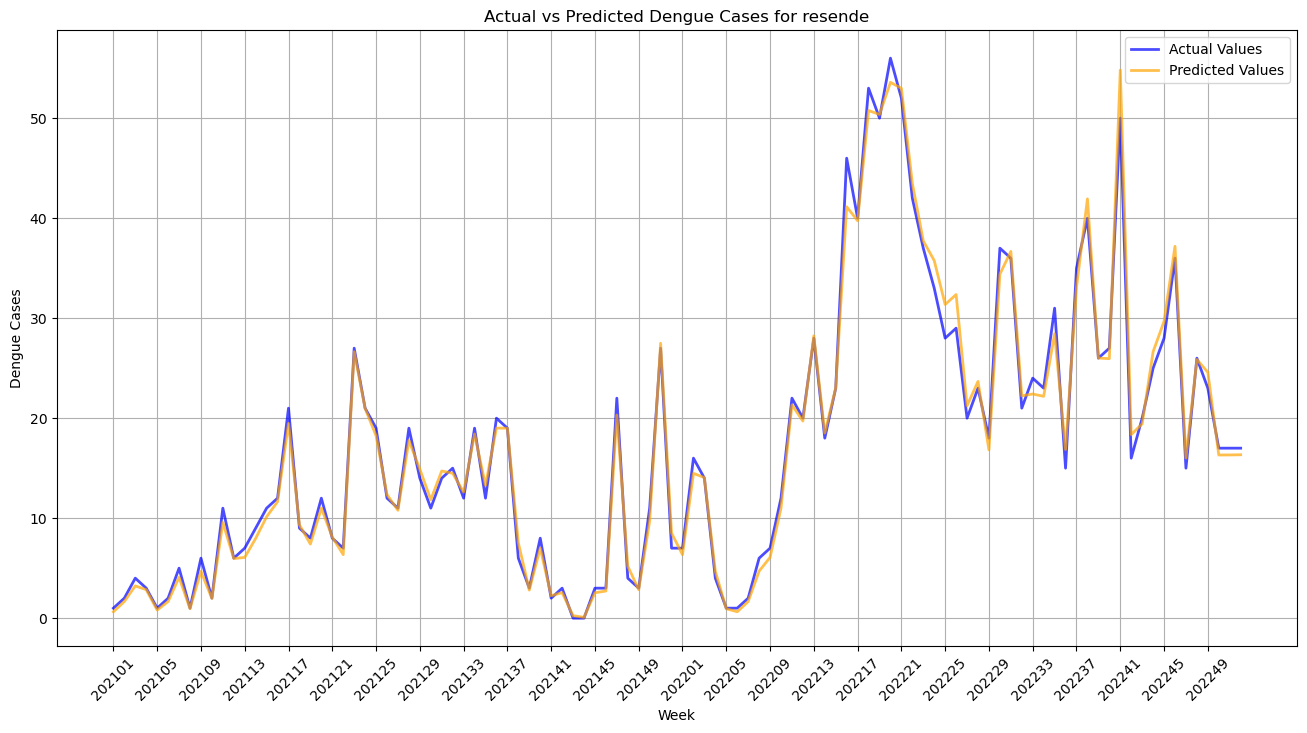


City: rio das ostras, RMSE: 2.288749912524028


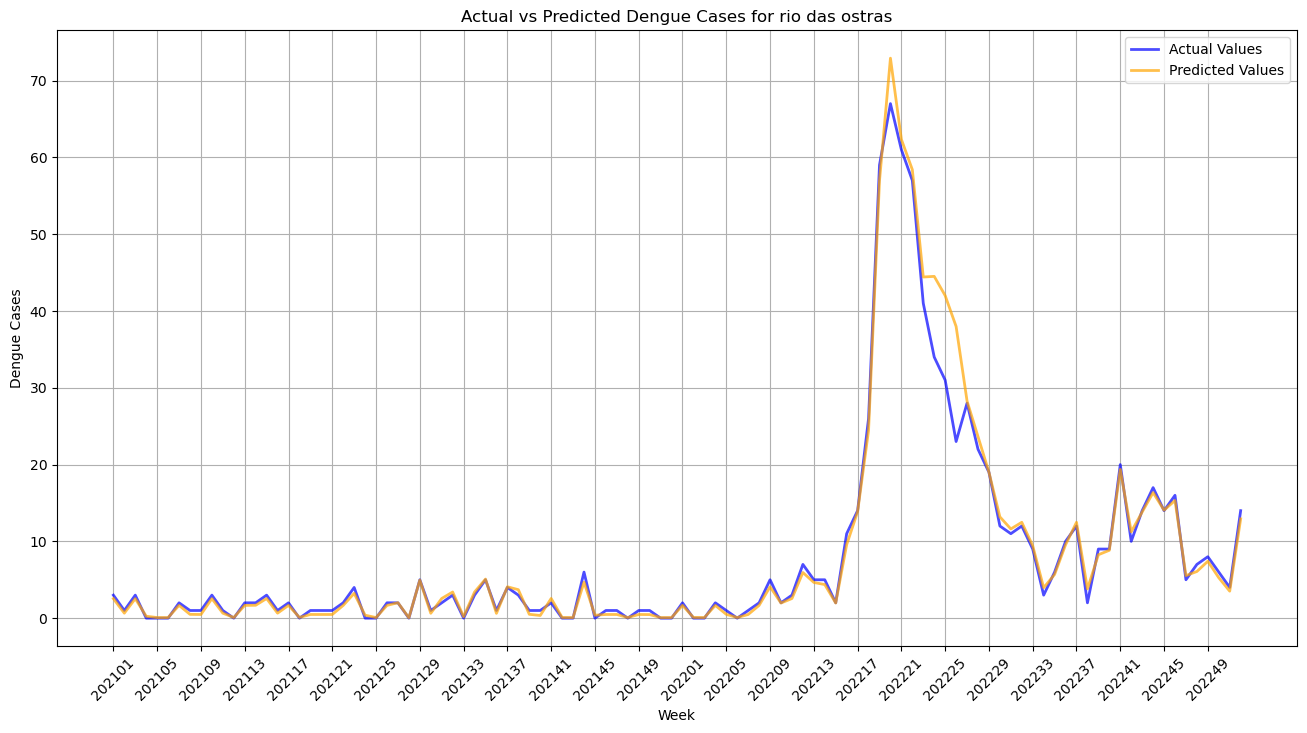


City: rio de janeiro, RMSE: 3.713080887428729


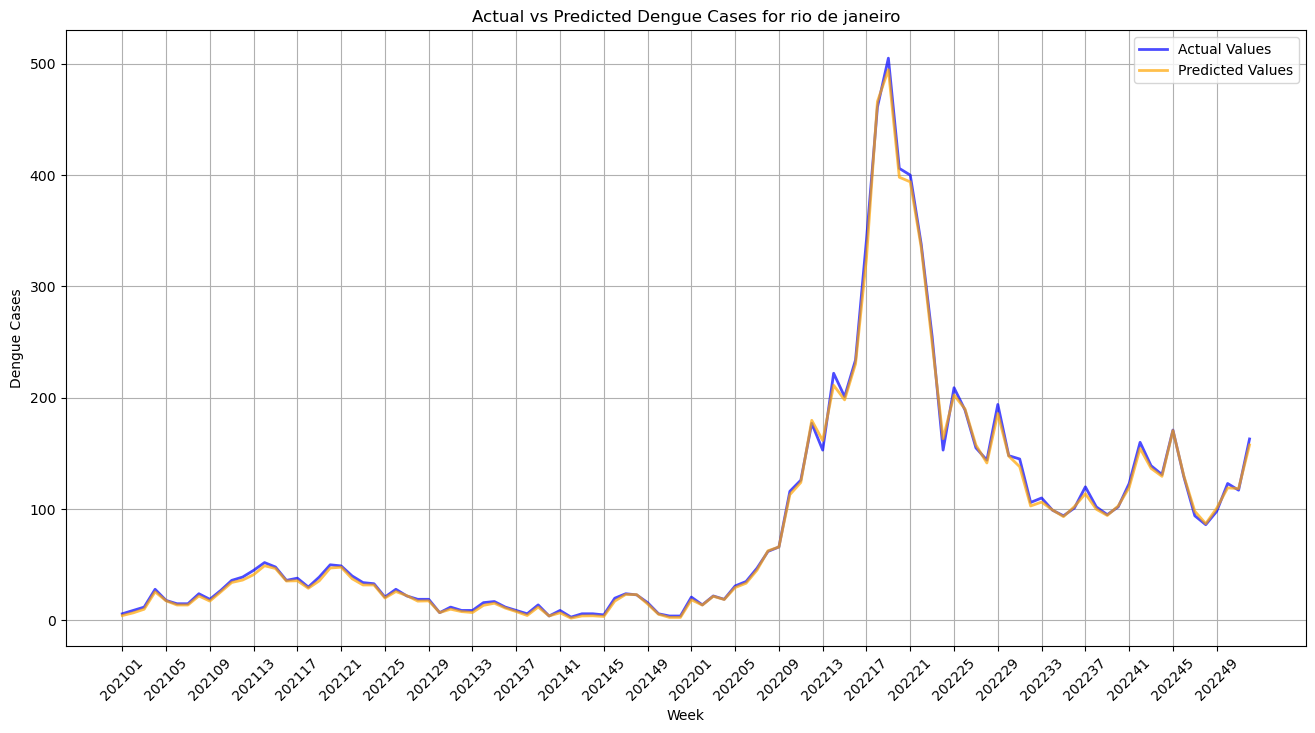


City: santo antônio de pádua, RMSE: 0.5877762460844472


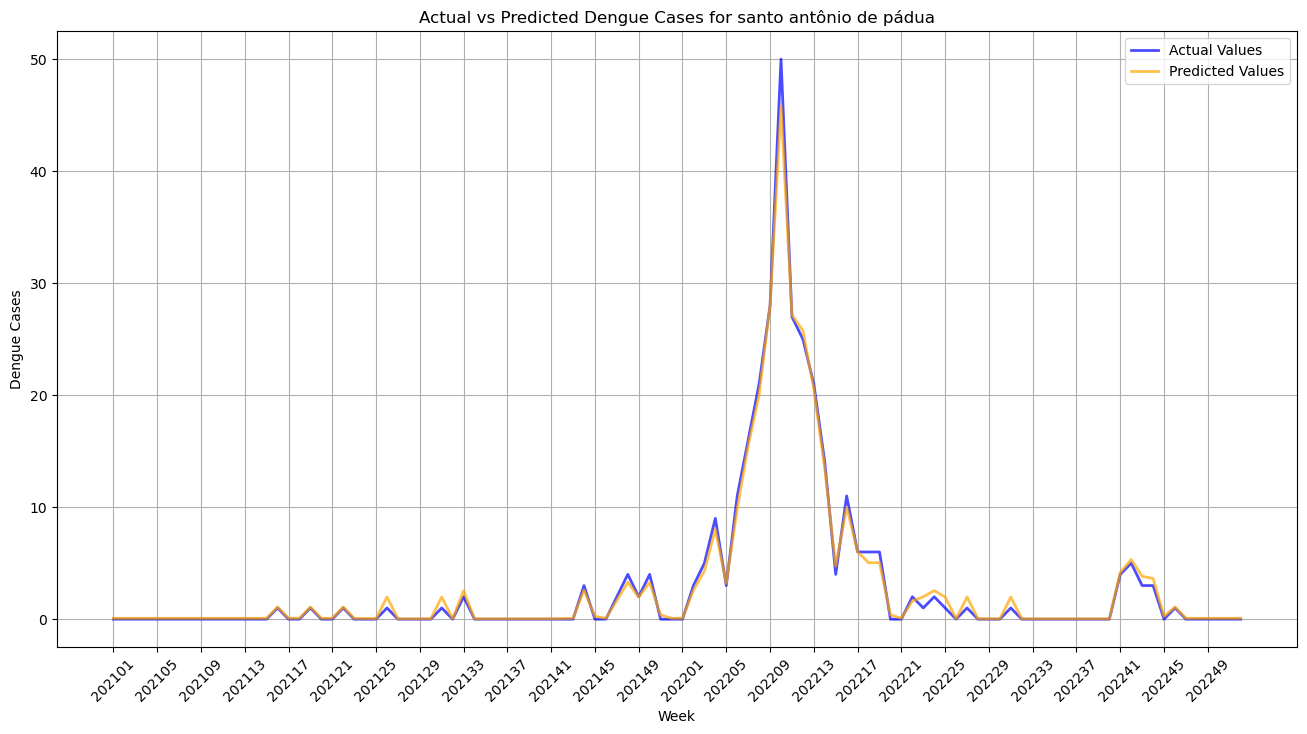


City: são gonçalo, RMSE: 0.9435766200442846


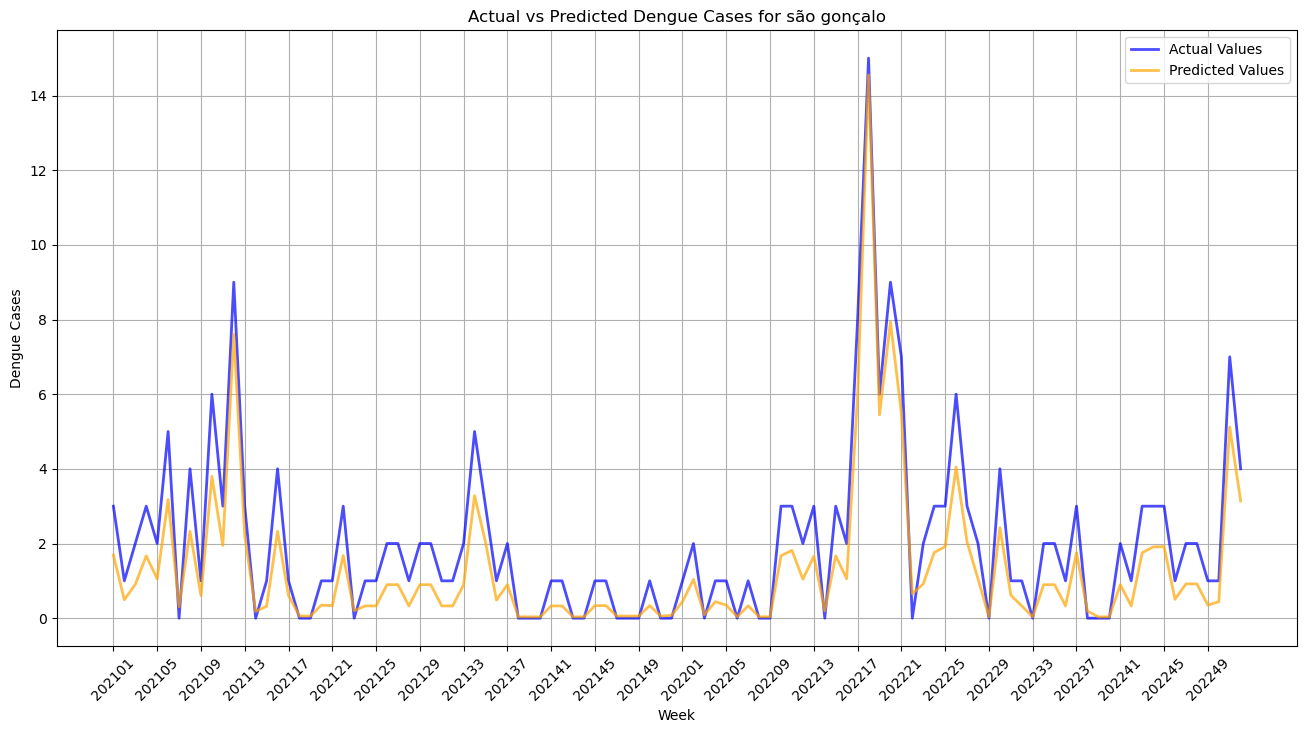


City: são joão de meriti, RMSE: 0.6105788899566528


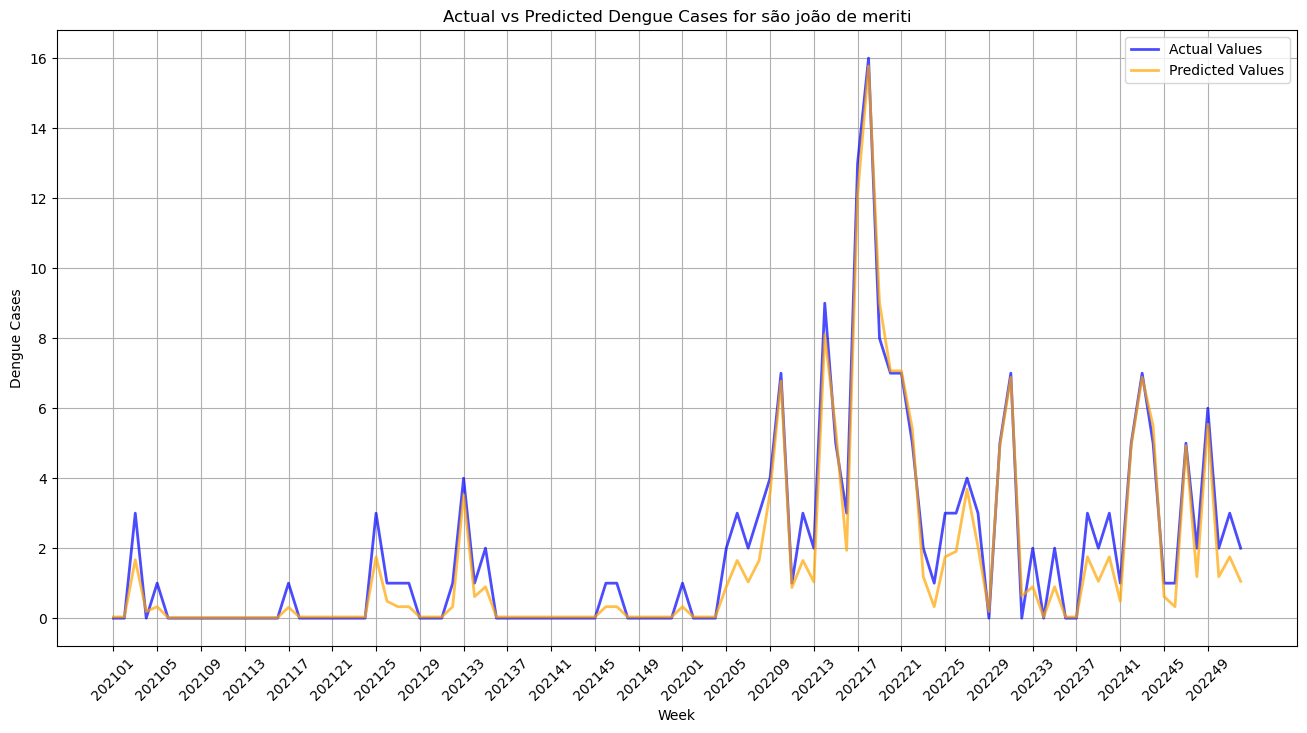


City: são pedro da aldeia, RMSE: 0.36510223814782505


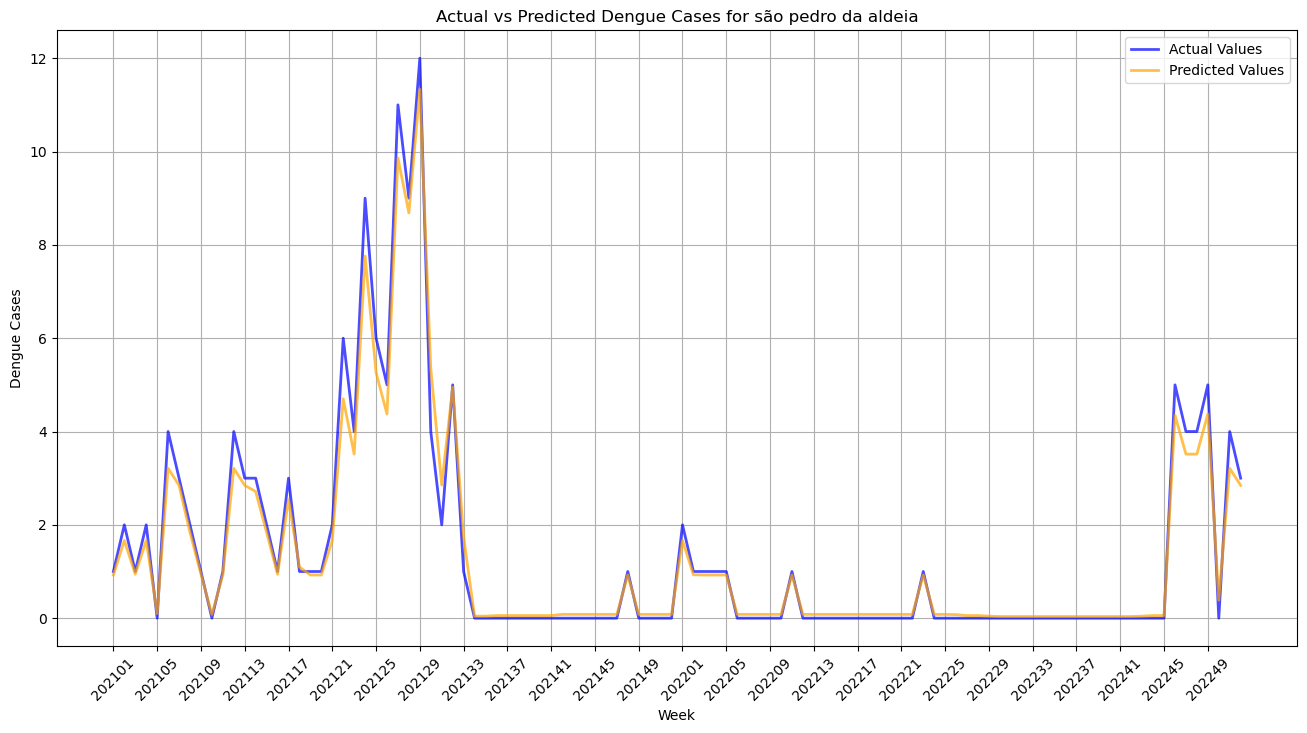


City: saquarema, RMSE: 0.5392998903461919


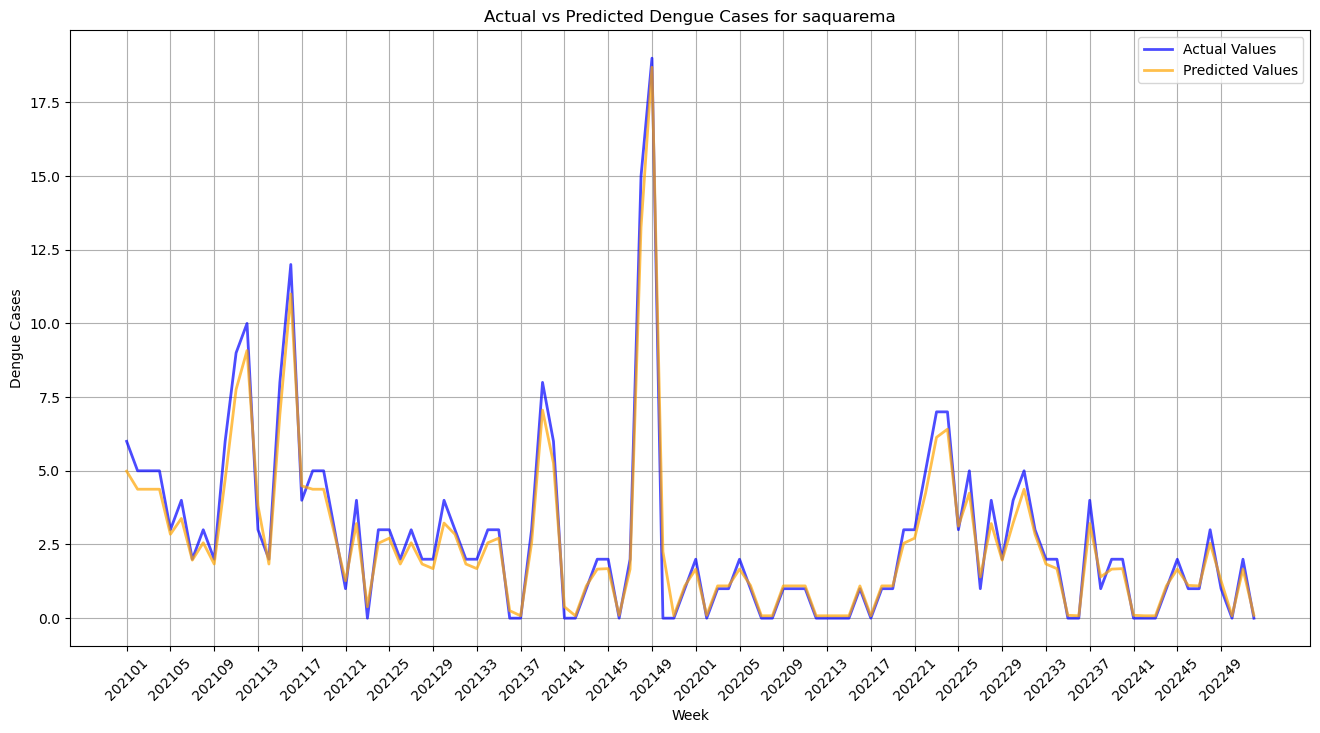


City: seropédica, RMSE: 2.0197432999060663


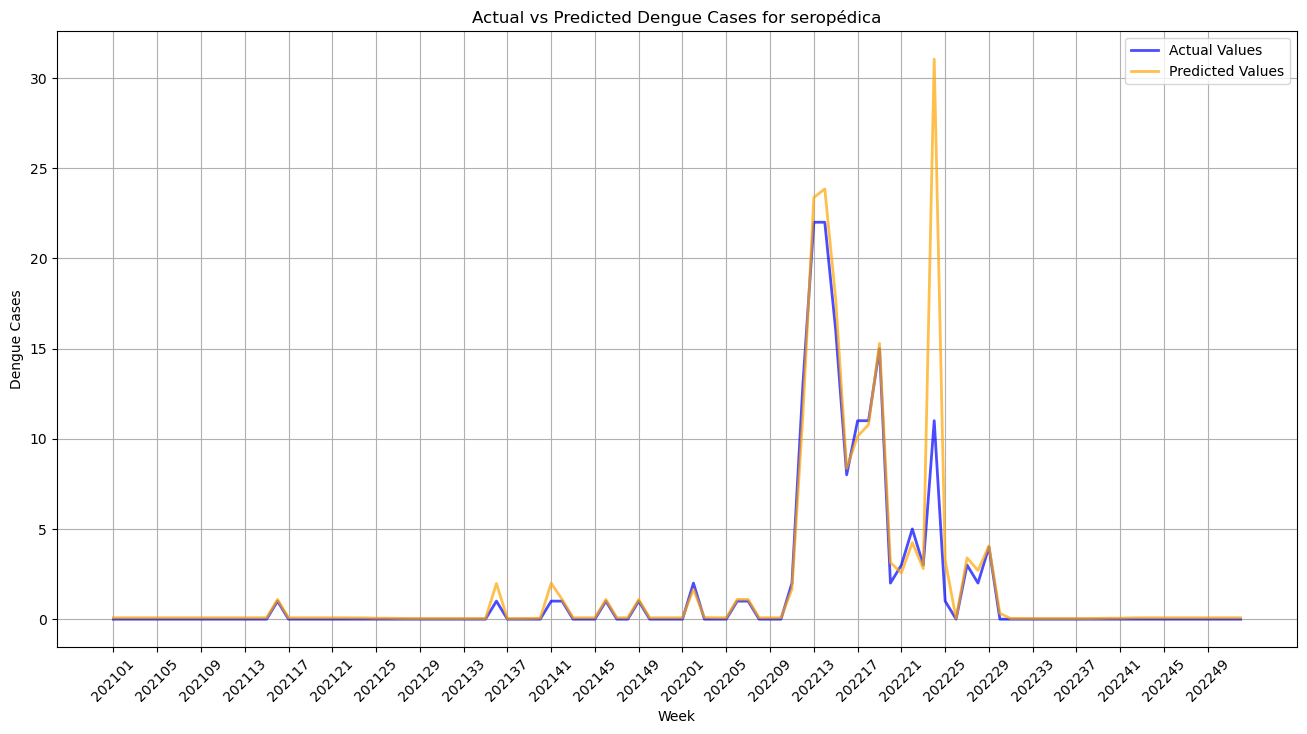


City: valença, RMSE: 0.5129362289497797


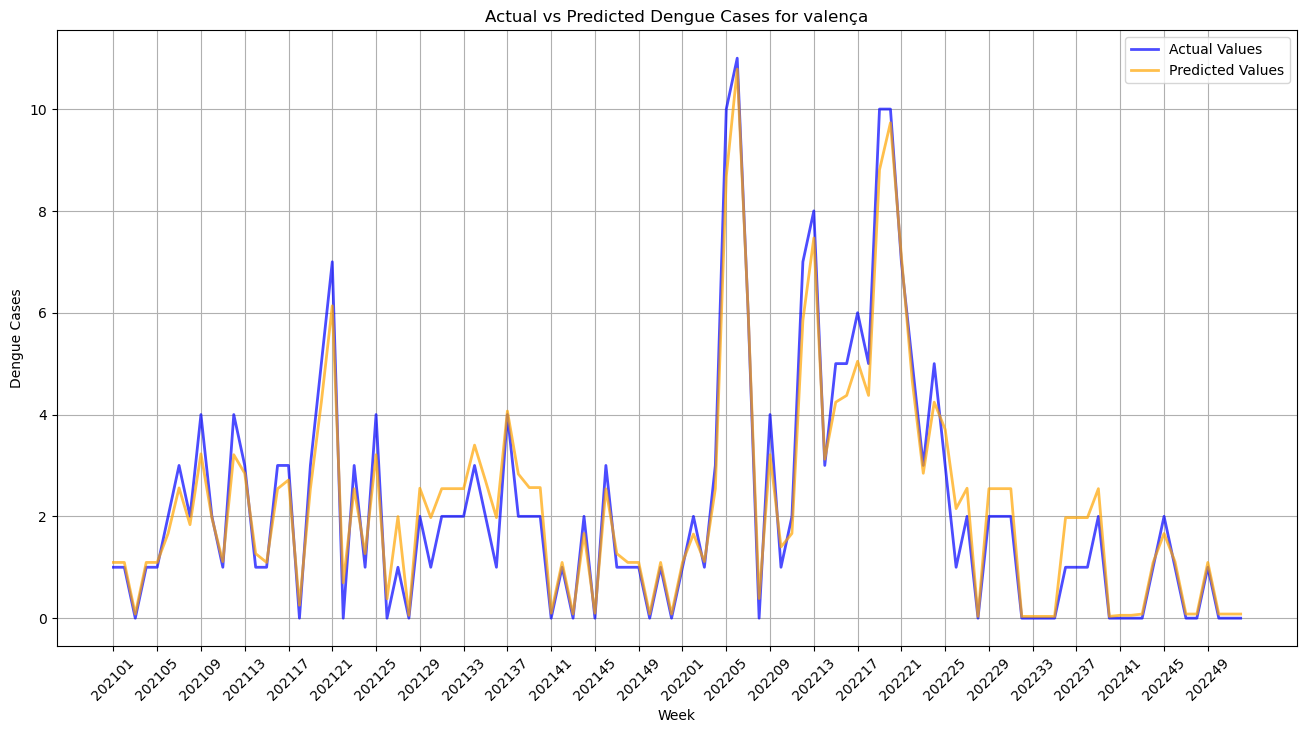


City: vassouras, RMSE: 0.47890639810333735


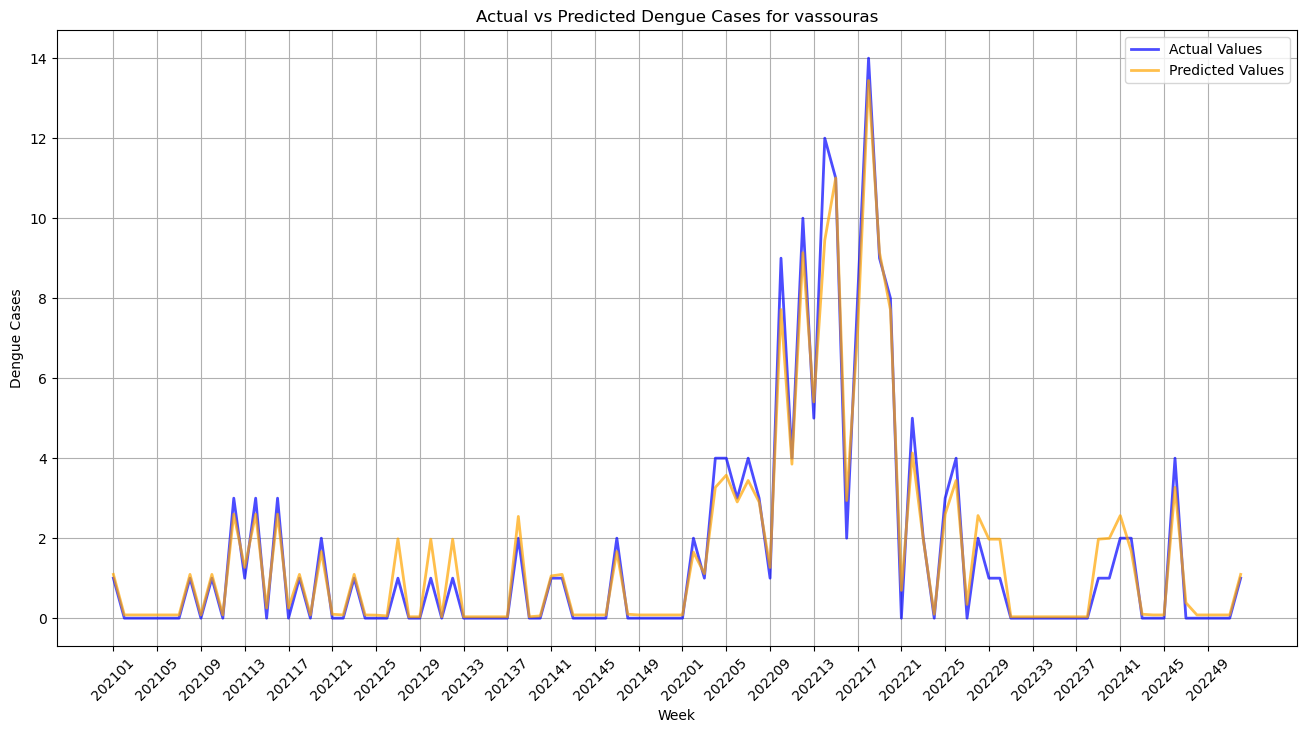


City: volta redonda, RMSE: 0.5479962237472443


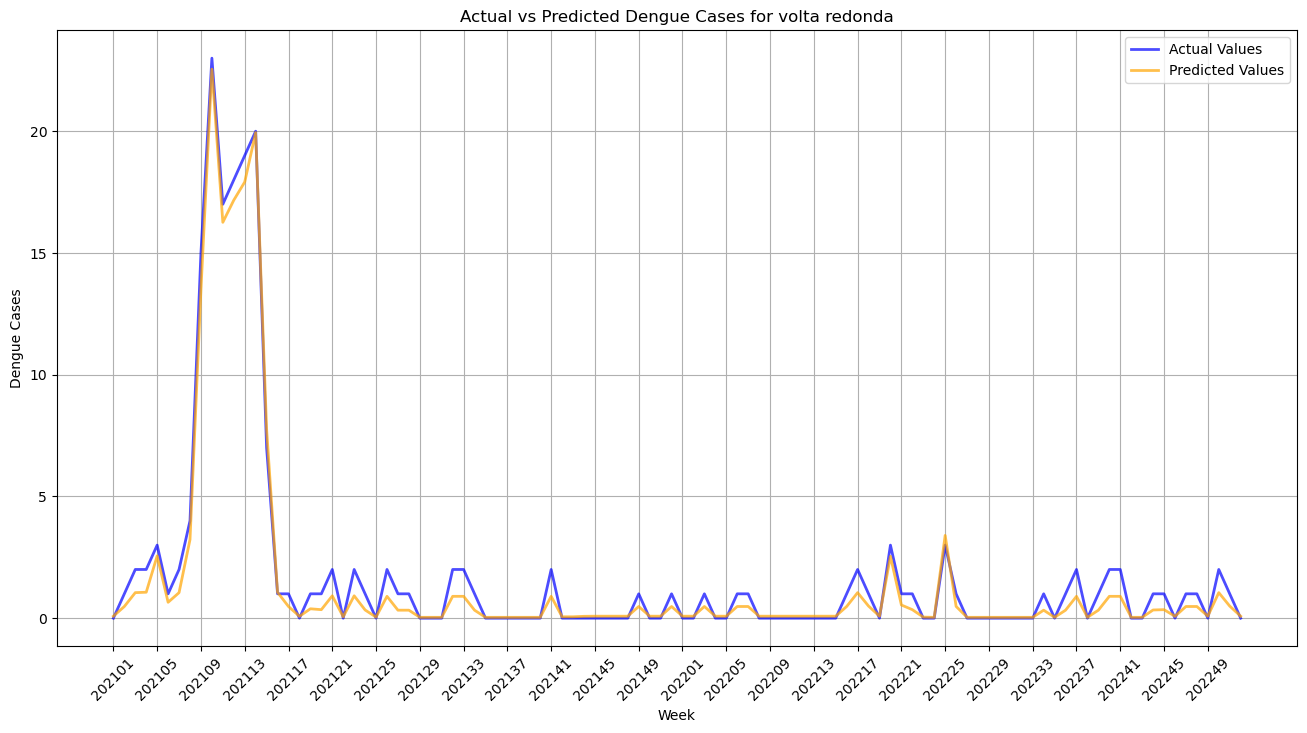

In [48]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

for city, indices in city_index_map.items():
    y_actual_city = y_actual[indices]
    y_pred_city = y_pred[indices]
    weeks_city = test_data.loc[indices, 'week'].astype(str)

    if np.max(y_actual_city) < 10:
        continue
    

    rmse_city = np.sqrt(mean_squared_error(y_actual_city, y_pred_city))
    print(f'\nCity: {city}, RMSE: {rmse_city}')
    plt.figure(figsize=(16, 8))
    plt.plot(weeks_city, y_actual_city, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
    plt.plot(weeks_city, y_pred_city, label='Predicted Values', color='orange', alpha=0.7, linewidth=2)

    plt.xlabel('Week')
    plt.ylabel('Dengue Cases')
    plt.title(f'Actual vs Predicted Dengue Cases for {city}')
    plt.legend()
    plt.grid(True)
    plt.xticks(weeks_city[::4], rotation=45)
    plt.show()